# <div style="color:orange;">[Olist] Segmentation clients - Analyse</div>

<img src="img/olist_logo.jpg" style="height: 150px;">

# <div style="color:blue" id="ch0">0. Plan du Notebook</div>

1. [Contexte et description du jeu de données](#ch1)<br><br>
2. [Imports et fonctions générales](#ch2)<br>
3. [Analyse exploratoire](#ch3)<br>
>3.1 [Analyse : Geolocation](#ch3_1)<br>
>3.2 [Analyse : Customers](#ch3_2)<br>
>3.3 [Analyse : Orders](#ch3_3)<br>
>3.4 [Analyse : Reviews](#ch3_4)<br>
>3.5 [Analyse : Payments](#ch3_5)<br>
>3.6 [Analyse : Items](#ch3_6)<br>
>3.7 [Analyse : Products](#ch3_7)<br>
>3.8 [Analyse : Sellers](#ch3_8)<br>

4. [Feature engineering](#ch4)<br>
>3.1 [FE : RFM](#ch4_1)<br>
>3.2 [FE : Aggrégations et nouvelles variables](#ch4_2)<br>

5. [Conclusion](#ch5)

# <div id="ch1" style="color: blue">1. Contexte et description du jeu de données</div>

<div class="alert alert-block alert-warning">
    <b><u>Objectif</u></b><br>
    
Mettre en œuvre une <b>segmentation des clients</b> dont la logique sous-jacente doit être explicitée.<br>

Dans l'optique d'aboutir à un contrat de maintenance, la <b>stabilité dans le temps</b> de cette semgmentation doit être précisée.
</div>

<img src="img/olist_db.png" style="height: 400px;">

Dans ce notebook, nous allons réaliser une analyse exploratoire des jeux de données contenus dans la base dont le schéma se trouve ci-dessus, et aboutir à la création de plusieurs datasets agrégés dont la pertinence pourra ensuite être confrontée à différents modèles de clustering.

[*(Retour sommaire)*](#ch0)

# <div id="ch2" style="color: blue">2. Imports et fonctions générales</div>

In [1]:
import re
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, MarkerCluster, Icon
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 122)
pd.set_option('display.max_row', 122)

In [2]:
# Source : https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(7,6))
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, 
                             illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:  
            fig = plt.figure(figsize=(7,6))
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2],
                                alpha=alpha, label=value)
                plt.legend()
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    
def display_pca(df, split=None, n_comp=6): 
    X = df.values
    features = df.columns
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_comp)
    pca.fit(X_scaled)
    display_scree_plot(pca)
    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))
    #display_circles(pcs, n_comp, pca, [(0,1)], lims=[.0155, .019, 0.053, .057], labels=np.array(features))
    #display_circles(pcs, n_comp, pca, [(2,3)], lims=[-.035, -.026, -.03,-.016], labels=np.array(features))
    X_projected = pca.transform(X_scaled)
    display_factorial_planes(X_projected, n_comp, pca, 
                             [(0,1),(2,3),(4,5)], alpha=0.5, illustrative_var=split)
    plt.show()

In [3]:
def display_distri(df, dataset_name=None, quali=False, bins=None):
    for c in df.columns:
        plt.figure()
        if (quali == False) & (bins != None):
            sns.histplot(data=df[c], bins=bins)
        else:
            sns.histplot(data=df[c])
        if dataset_name == None:
            plt.title(f"Distribution de {c}")
        else:
            plt.title(f"Distribution de {dataset_name}.{c}")
        if (len(df[c].unique()) > 4) & (quali == True):
            plt.xticks(rotation=90)
        plt.show()

In [4]:
#Source : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
#Source : https://stackoverflow.com/questions/8595973/truncate-to-three-decimals-in-python
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [6]:
def calc_distance(state1, state2):
    lat1 = float(geo_st.loc[geo_st['geolocation_state'] == state1, 'geolocation_lat'])
    lng1 = float(geo_st.loc[geo_st['geolocation_state'] == state1, 'geolocation_lng'])
    lat2 = float(geo_st.loc[geo_st['geolocation_state'] == state2, 'geolocation_lat'])
    lng2 = float(geo_st.loc[geo_st['geolocation_state'] == state2, 'geolocation_lng'])
    dep = (lat1, lng1)
    arr = (lat2, lng2)
    return geodesic(dep, arr).km

In [7]:
def calc_distance_coord(lat1, lng1, lat2, lng2):
    dep = (lat1, lng1)
    arr = (lat2, lng2)
    return geodesic(dep, arr).km

In [8]:
geo = pd.read_csv('data/olist_geolocation_dataset.csv')
cus = pd.read_csv('data/olist_customers_dataset.csv')
itm = pd.read_csv('data/olist_order_items_dataset.csv')
pay = pd.read_csv('data/olist_order_payments_dataset.csv')
rev = pd.read_csv('data/olist_order_reviews_dataset.csv')
ods = pd.read_csv('data/olist_orders_dataset.csv')
pro = pd.read_csv('data/olist_products_dataset.csv')
sel = pd.read_csv('data/olist_sellers_dataset.csv')

[*(Retour sommaire)*](#ch0)

# <div id="ch3" style="color: blue">3. Analyse exploratoire</div>

## <div id="ch3_1" style="color: orange;">3.1 Geolocation</div>

In [9]:
geo.shape

(1000163, 5)

In [10]:
geo.describe(include='all')

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,1.000163e+06,1.000163e+06,1.000163e+06,1000163,1000163
unique,NaN,NaN,NaN,8011,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,135800,404268
mean,3.657417e+04,-2.117615e+01,-4.639054e+01,NaN,NaN
std,3.054934e+04,5.715866e+00,4.269748e+00,NaN,NaN
min,1.001000e+03,-3.660537e+01,-1.014668e+02,NaN,NaN
25%,1.107500e+04,-2.360355e+01,-4.857317e+01,NaN,NaN
50%,2.653000e+04,-2.291938e+01,-4.663788e+01,NaN,NaN
75%,6.350400e+04,-1.997962e+01,-4.376771e+01,NaN,NaN


In [11]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


<AxesSubplot:>

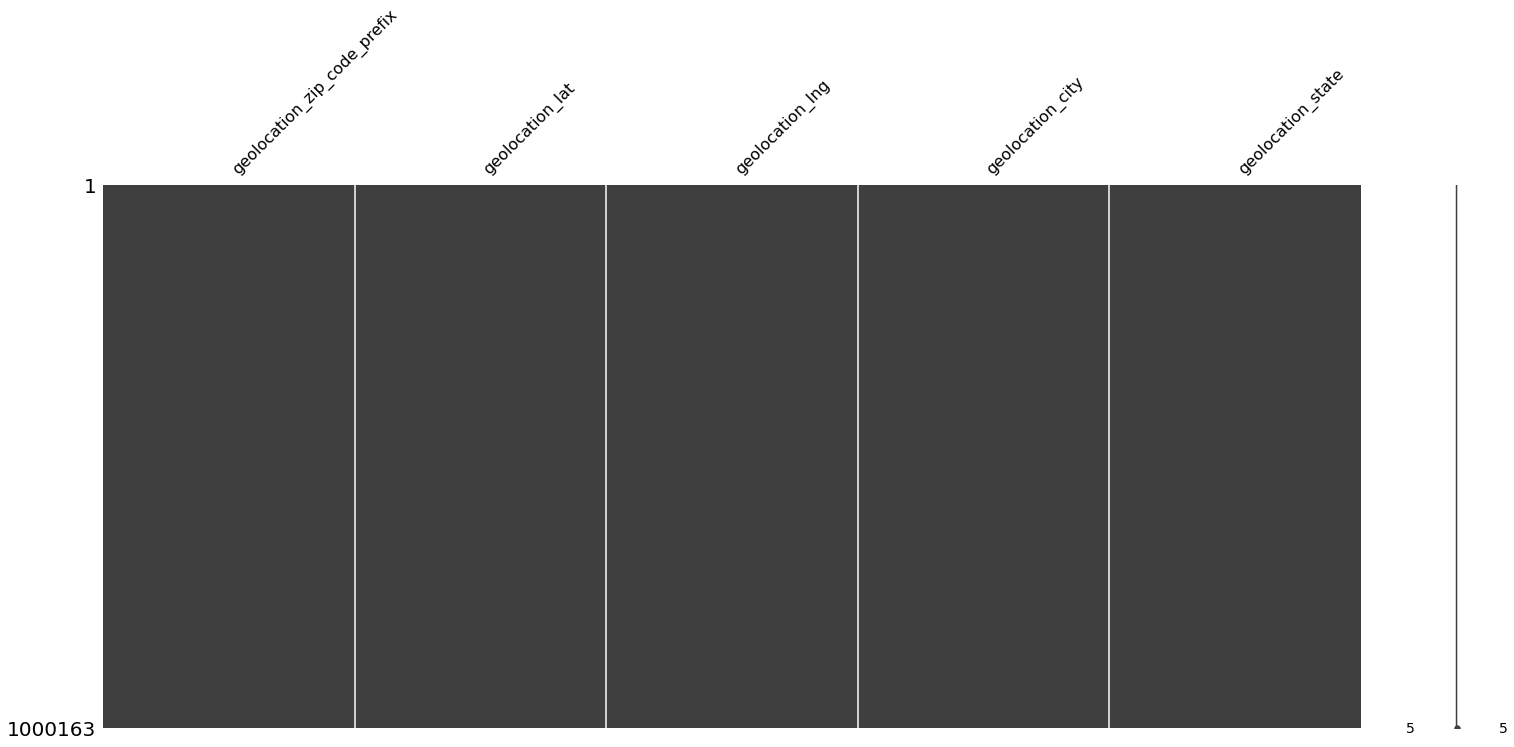

In [12]:
msno.matrix(geo)

In [13]:
(geo.isna().sum()/geo.shape[0]).sort_values(ascending=False)

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

In [14]:
geo_quali = geo.select_dtypes(exclude=np.number)
geo_quanti = geo.select_dtypes(include=np.number)

In [15]:
geo_grp = geo.groupby('geolocation_city').count().sort_values(by='geolocation_lat', ascending=False).reset_index()
geo_grp[['geolocation_city', 'geolocation_zip_code_prefix']].head(5)

,geolocation_city,geolocation_zip_code_prefix
0,sao paulo,135800
1,rio de janeiro,62151
2,belo horizonte,27805
3,são paulo,24918
4,curitiba,16593


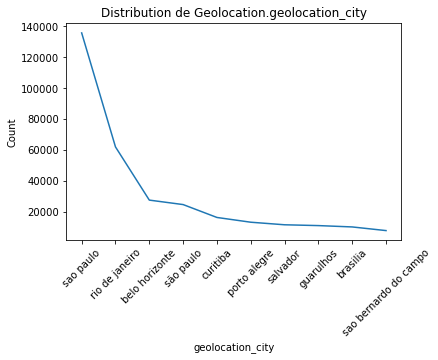

In [16]:
plt.figure()
sns.lineplot(data=geo_grp.head(10), x='geolocation_city', y='geolocation_state')
plt.ylabel('Count')
plt.title(f"Distribution de Geolocation.geolocation_city")
plt.xticks(rotation=45)
plt.show()

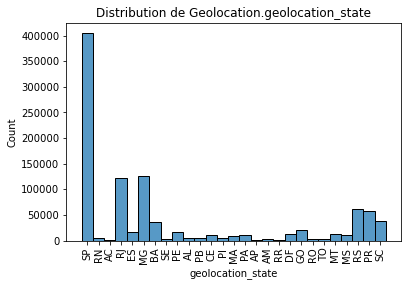

In [17]:
plt.figure()
sns.histplot(data=geo['geolocation_state'])
plt.title(f"Distribution de Geolocation.geolocation_state")
plt.xticks(rotation=90)
plt.show()

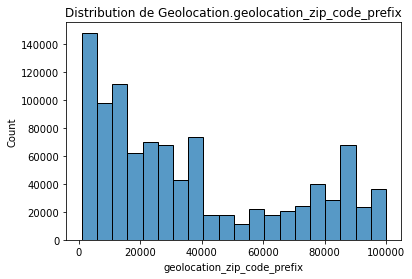

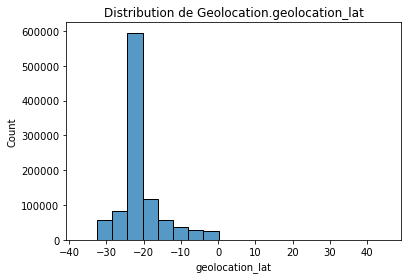

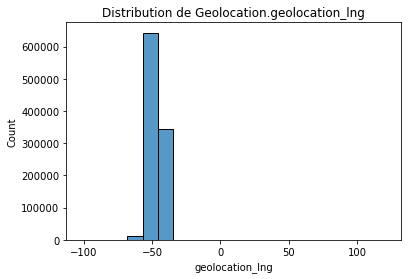

In [18]:
display_distri(geo_quanti, dataset_name='Geolocation', bins=20)

In [19]:
geolocator = Nominatim(user_agent="Brazil", timeout=10)
geo_doute = geo.loc[(geo['geolocation_lat'] > 5.2722222) |
                    (geo['geolocation_lat'] < -33.7422222) |
                    (geo['geolocation_lng'] > -34.791666666666664) |
                    (geo['geolocation_lng'] < -73.99222222222222), ['geolocation_lat', 'geolocation_lng']]
geo_doute['country'] = geo_doute.apply(
    lambda x: geolocator.reverse(f"{x['geolocation_lat']},{x['geolocation_lng']}").raw['address'].get('country', ''),
    axis=1)
geo_doute['country'].unique()

array(['España', 'Portugal', 'Argentina', 'Italia', 'United States',
       'México', 'Brasil', 'Pilipinas / Philippines'], dtype=object)

In [20]:
len(geo_doute)

42

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Geolocation</b><br>
    
On constate que les localisations enregistrées sont très concentrées : les 5 premières villes accaparent 25% des lignes, et les 6 premiers états concentrent 75% des lignes (pour rappel, le Brésil est une fédération qui compte 27 Etats).
    
Néanmoins, en observant les coordinnées GPS hors des limites du pays, on s'aperçoit que l'entreprise a quelques connexions avec d'autres pays, la plupart n'étant pas limitrophes (à part l'Argentine). Nous regarderons dans les autres tables si ces connexions concernent des rapports commerciaux ou d'approvisionnement.
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch3_2" style="color: orange;">3.2 Customers</div>

In [21]:
cus.shape

(99441, 5)

In [22]:
cus.describe(include='all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


In [23]:
print(f"Valeur uniques de customer_zip_code_prefix : {len(cus.customer_zip_code_prefix.unique())}")

Valeur uniques de customer_zip_code_prefix : 14994


In [24]:
cus.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


<AxesSubplot:>

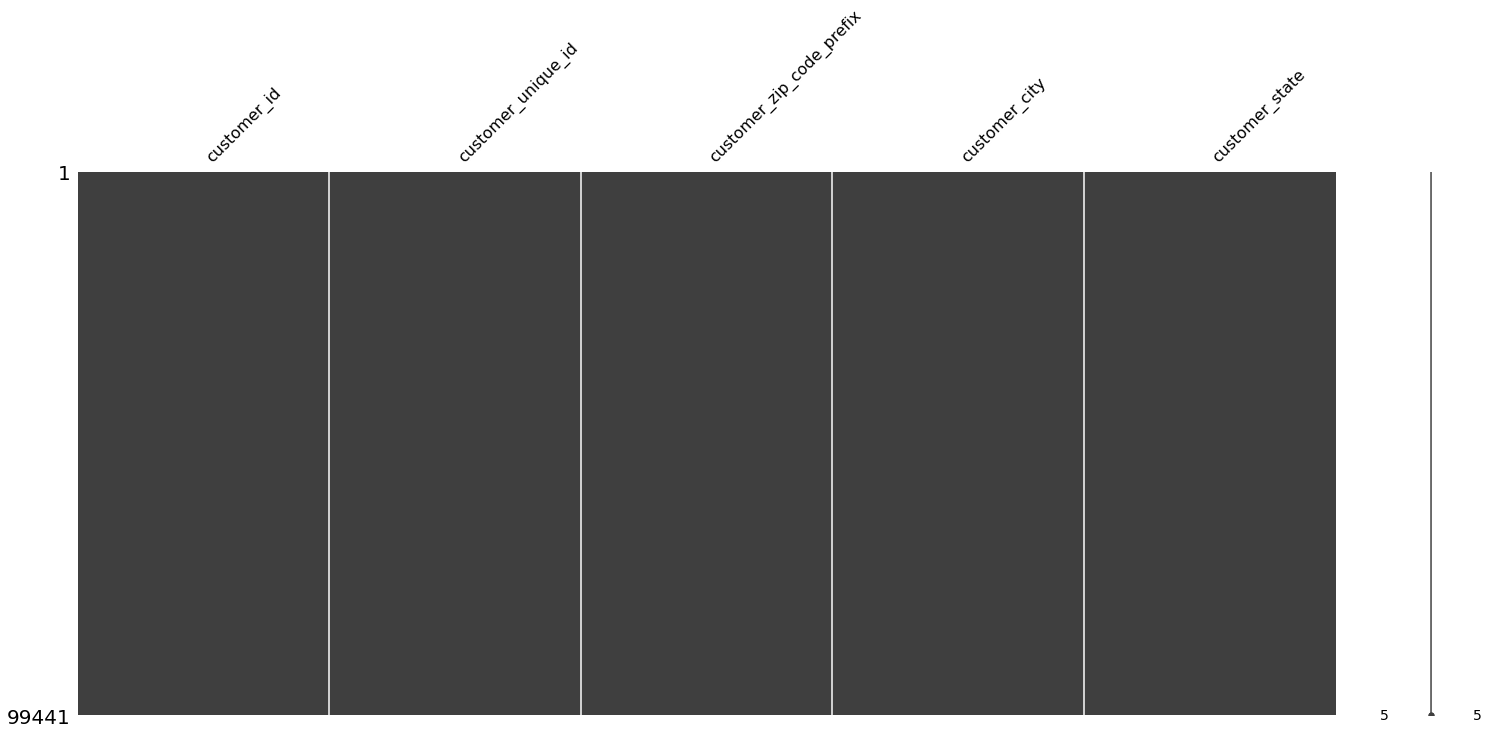

In [25]:
msno.matrix(cus)

In [26]:
(cus.isna().sum()/cus.shape[0]).sort_values(ascending=False)

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

In [27]:
cus_city = cus.groupby('customer_city').count().sort_values(by='customer_id', ascending=False).reset_index()
cus_city[['customer_city', 'customer_id']].head(5)

,customer_city,customer_id
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521


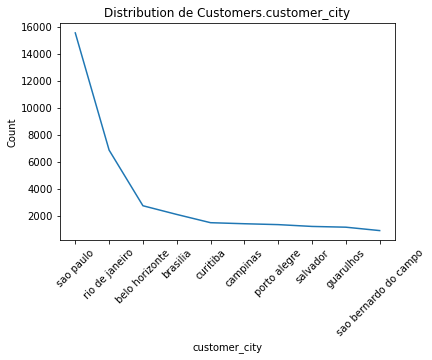

In [28]:
plt.figure()
sns.lineplot(data=cus_city.head(10), x='customer_city', y='customer_id')
plt.ylabel('Count')
plt.title(f"Distribution de Customers.customer_city")
plt.xticks(rotation=45)
plt.show()

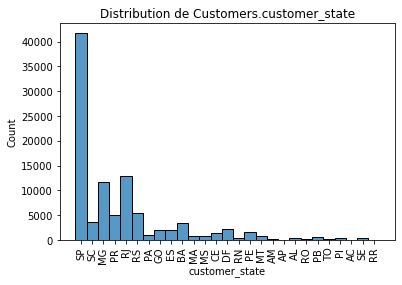

In [29]:
plt.figure()
sns.histplot(data=cus['customer_state'])
plt.title(f"Distribution de Customers.customer_state")
plt.xticks(rotation=90)
plt.show()

In [9]:
nb_clients = len(cus['customer_unique_id'].unique())
cus_unique = cus.groupby('customer_unique_id').count().reset_index()
cus_several = cus_unique[cus_unique['customer_id'] > 1]
cus['nb_orders'] = 1
for i, r in cus_several.iterrows():
    cus.loc[cus['customer_unique_id'] == r['customer_unique_id'], ['nb_orders']] = r['customer_id']

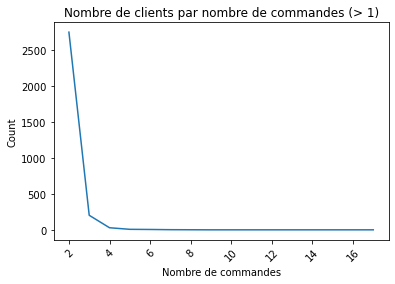

In [17]:
cus_sup_1 = cus_several.groupby('customer_id').count().reset_index()
plt.figure()
sns.lineplot(data=cus_sup_1, x='customer_id', y='customer_zip_code_prefix')
plt.ylabel('Count')
plt.xlabel('Nombre de commandes')
plt.title(f"Nombre de clients par nombre de commandes (> 1)")
plt.xticks(rotation=45)
plt.show()

In [32]:
print(f"Nombre de clients uniques : {len(cus_unique)}")
print(f"Nombre de clients ayant placé au moins 2 commandes : {len(cus_several)} ({np.round(len(cus_several) / len(cus_unique), 3) * 100}%)")

Nombre de clients uniques : 96096
Nombre de clients ayant placé au moins 2 commandes : 2997 (3.1%)


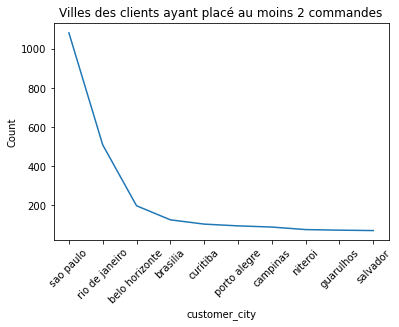

In [33]:
city_sup_1 = cus[cus['nb_orders'] > 1].groupby('customer_city').count().sort_values(by='customer_id', ascending=False).head(10)
plt.figure()
sns.lineplot(data=city_sup_1, x='customer_city', y='customer_id')
plt.ylabel('Count')
plt.title(f"Villes des clients ayant placé au moins 2 commandes")
plt.xticks(rotation=45)
plt.show()

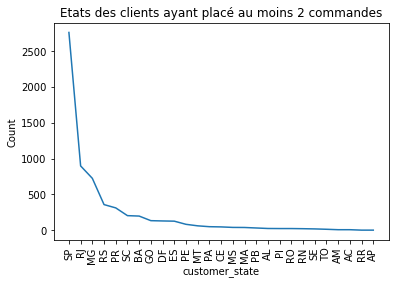

In [34]:
state_sup_1 = cus[cus['nb_orders'] > 1].groupby('customer_state').count().sort_values(by='customer_id', ascending=False)
plt.figure()
sns.lineplot(data=state_sup_1, x='customer_state', y='customer_id')
plt.ylabel('Count')
plt.title(f"Etats des clients ayant placé au moins 2 commandes")
plt.xticks(rotation=90)
plt.show()

In [10]:
geo_short = geo.loc[:, ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']]
geo_short.rename(columns={'geolocation_zip_code_prefix': 'zip', 'geolocation_lat': 'lat', 'geolocation_lng': 'lng'}, inplace=True)
geo_short.drop_duplicates('zip', keep='first', inplace=True)
cus_short = cus.loc[:, ['customer_zip_code_prefix', 'customer_unique_id', 'customer_state', 'nb_orders']]
cus_short.rename(columns={'customer_zip_code_prefix': 'zip', 'customer_unique_id': 'id', 'customer_state': 'state'}, inplace=True)
cus_short.drop_duplicates(inplace=True)

In [11]:
cus_geo = pd.merge(cus_short, geo_short, how='left', on='zip')
cus_geo.shape

(96350, 6)

In [186]:
print("Localisation de la totalité des commandes :")
print()
states = cus_geo['state'].unique()
m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=(-19.5, -54.39), zoom=3)
for s in states:
    markers = [Marker(location=(r['lat'], r['lng'])) 
               for idx, r in cus_geo[cus_geo['state'] == s].iterrows()]
    cluster = MarkerCluster(markers=tuple(markers))
    m.add_layer(cluster)
m

Localisation de la totalité des commandes :



Map(center=[-19.5, -54.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

<img src="img/leaf_all_orders.png">

In [12]:
print("Localisation des clients ayant placé au moins 2 commandes :")
print()
states = cus_geo['state'].unique()
m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=(-19.5, -54.39), zoom=3)
for s in states:
    markers = [Marker(location=(r['lat'], r['lng'])) 
               for idx, r in cus_geo[(cus_geo['nb_orders'] > 1) & (cus_geo['state'] == s)].iterrows()]
    cluster = MarkerCluster(markers=tuple(markers))
    m.add_layer(cluster)
m

Localisation des clients ayant placé au moins 2 commandes :



C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Map(center=[-19.5, -54.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

<img src="img/leaf_orders_sup_1.png">

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Customers</b><br>
    
La table `Customers` présente des redondances avec la table `Geolocation` : en effet, la relation entre les différents niveaux hiérarchiques de localisation sont tels que :

$$ZIP \subset CITY \subset STATE$$
    
Ainsi, d'un point de vue normatif (3FN), les colonnes `customer_city` et `customer_state` sont ici redondantes et donc inutiles.
    
On apprend en outre plusieurs informations intéressantes sur les clients :
- Seuls 3% des 96.096 clients ont placé plus d'une seule commande chez Olist
- La distribution des clients (par ville et par Etat) est identique chez les clients ayant placé une seule ou plusieurs commandes
- 5 villes détiennent 30% des clients : Sao Paulo, Rio de Janero, Belo Horizonte, Brazilia, Curitiba
- 3 Etats détiennent 60% des clients : Sao Paulo (SP), Rio de Janero (RJ), Minas Gerais (MG)
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch3_3" style="color: orange;">3.3 Orders</div>

In [40]:
ods.shape

(99441, 8)

In [41]:
ods.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [42]:
ods.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [12]:
for c in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
          'order_delivered_customer_date', 'order_estimated_delivery_date']:
    ods[c] = ods[c].astype(np.datetime64)
ods.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [44]:
ods.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


<AxesSubplot:>

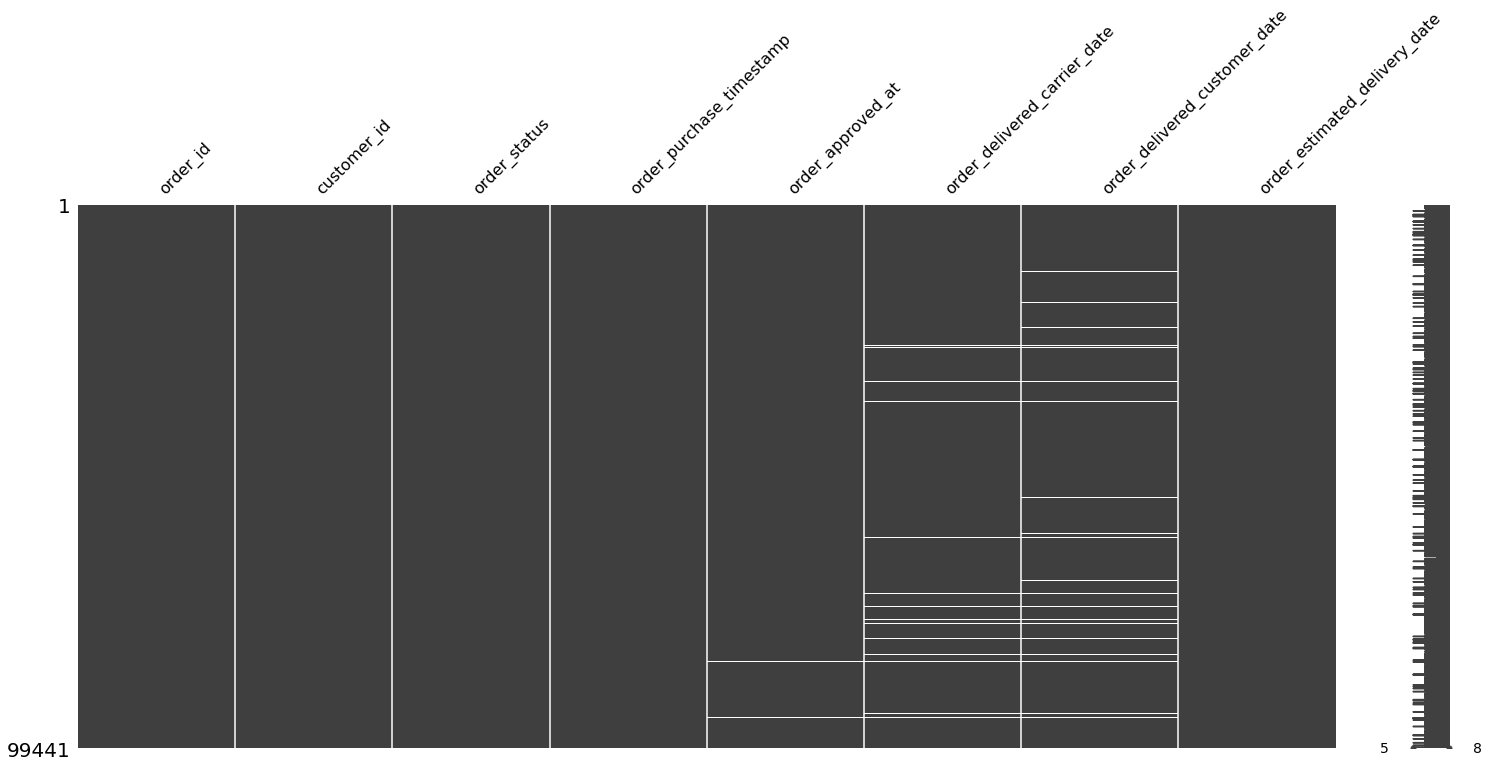

In [45]:
msno.matrix(ods)

In [46]:
(ods.isna().sum()/ods.shape[0]).sort_values(ascending=False)

order_delivered_customer_date    0.029817
order_delivered_carrier_date     0.017930
order_approved_at                0.001609
order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_estimated_delivery_date    0.000000
dtype: float64

In [47]:
print("Valeurs uniques de statut de la commande :")
ods['order_status'].unique()

Valeurs uniques de statut de la commande :


array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

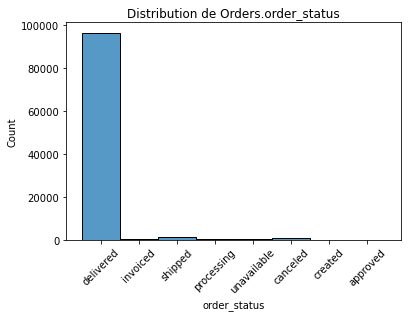

In [48]:
plt.figure()
sns.histplot(data=ods['order_status'])
plt.title(f"Distribution de Orders.order_status")
plt.xticks(rotation=45)
plt.show()

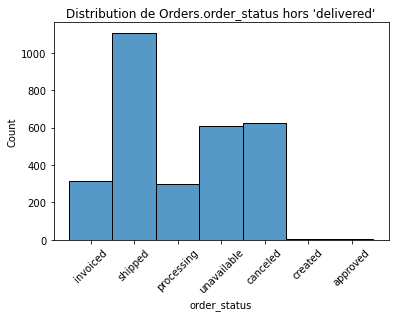

In [49]:
plt.figure()
sns.histplot(data=ods.loc[ods['order_status'] != 'delivered', 'order_status'])
plt.title(f"Distribution de Orders.order_status hors 'delivered'")
plt.xticks(rotation=45)
plt.show()

In [50]:
print('Ordre des timestamps (possibles outliers)')
print('-----------------------------------------')
print()
print(f"Approbation avant achat : {len(ods[ods['order_purchase_timestamp'] > ods['order_approved_at']])}")
print(f"Livraison estimée avant achat : {len(ods[ods['order_purchase_timestamp'] > ods['order_estimated_delivery_date']])}")
print(f"Livraison transporteur avant achat : {len(ods[ods['order_purchase_timestamp'] > ods['order_delivered_carrier_date']])}")
print(f"Livraison client avant achat : {len(ods[ods['order_purchase_timestamp'] > ods['order_delivered_customer_date']])}")
print(f"Livraison estimée avant approbation : {len(ods[ods['order_approved_at'] > ods['order_estimated_delivery_date']])}")
print(f"Livraison transporteur avant approbation : {len(ods[ods['order_approved_at'] > ods['order_delivered_carrier_date']])}")
print(f"Livraison client avant approbation : {len(ods[ods['order_approved_at'] > ods['order_delivered_customer_date']])}")
print(f"Livraison client avant livraison transporteur : {len(ods[ods['order_delivered_carrier_date'] > ods['order_delivered_customer_date']])}")

Ordre des timestamps (possibles outliers)
-----------------------------------------

Approbation avant achat : 0
Livraison estimée avant achat : 0
Livraison transporteur avant achat : 166
Livraison client avant achat : 0
Livraison estimée avant approbation : 12
Livraison transporteur avant approbation : 1359
Livraison client avant approbation : 61
Livraison client avant livraison transporteur : 23


In [51]:
print('Possibles incohérences')
print('----------------------')
print()
print(f"Commandes livrées transporteur sans approbation : {len(ods[(ods['order_approved_at'].isna()) & (~ods['order_delivered_carrier_date'].isna())])}")
print(f"Commandes livrées client sans approbation : {len(ods[(ods['order_approved_at'].isna()) & (~ods['order_delivered_customer_date'].isna())])}")
print(f"Commandes livrées client sans livraison transporteur : {len(ods[(ods['order_delivered_carrier_date'].isna()) & (~ods['order_delivered_customer_date'].isna())])}")

Possibles incohérences
----------------------

Commandes livrées transporteur sans approbation : 14
Commandes livrées client sans approbation : 14
Commandes livrées client sans livraison transporteur : 1


In [52]:
print('Statistiques sur les livraisons')
print('-------------------------------')
print()
print(f"Commandes non remises au transporteur : {len(ods[ods['order_delivered_carrier_date'].isna()])} ({np.round(len(ods[ods['order_delivered_carrier_date'].isna()]) / 99441, 2) * 100}%)")
print(f"Commandes non remises au client : {len(ods[ods['order_delivered_customer_date'].isna()])} ({np.round(len(ods[ods['order_delivered_customer_date'].isna()]) / 99441, 3) * 100}%)")
print(f"Commandes annulées : {ods.loc[ods['order_status'] == 'canceled', 'order_status'].count()} ({np.round(ods.loc[ods['order_status'] == 'canceled', 'order_status'].count() / 99441, 3) * 100}%)")
print(f"Produits indisponibles : {ods.loc[ods['order_status'] == 'unavailable', 'order_status'].count()} ({np.round(ods.loc[ods['order_status'] == 'unavailable', 'order_status'].count() / 99441, 3) * 100}%)")
print(f"Commandes livrées en retard : {len(ods[ods['order_delivered_customer_date'] > ods['order_estimated_delivery_date']])} ({np.round(len(ods[ods['order_delivered_customer_date'] > ods['order_estimated_delivery_date']]) / 99441, 3) * 100}%)")

Statistiques sur les livraisons
-------------------------------

Commandes non remises au transporteur : 1783 (2.0%)
Commandes non remises au client : 2965 (3.0%)
Commandes annulées : 625 (0.6%)
Produits indisponibles : 609 (0.6%)
Commandes livrées en retard : 7827 (7.9%)


In [53]:
print()
print("Délais moyens cumulé entre chaque étape")
print("---------------------------------------")
print()
ods_full = ods.dropna(axis=0)
ods_full['ord_app'] = ods_full['order_approved_at'] - ods_full['order_purchase_timestamp']
ods_full['ord_car'] = ods_full['order_delivered_carrier_date'] - ods_full['order_purchase_timestamp']
ods_full['ord_cus'] = ods_full['order_delivered_customer_date'] - ods_full['order_purchase_timestamp']
ods_full['ord_est'] = ods_full['order_estimated_delivery_date'] - ods_full['order_purchase_timestamp']
print(f"Commande --> Approbation : {ods_full['ord_app'].mean()}")
print(f"Commande --> Transporteur : {ods_full['ord_car'].mean()}")
print(f"Commande --> Client : {ods_full['ord_cus'].mean()}")
print()
print(f"Pour comparaison :: Commande --> Livraison estimée : {ods_full['ord_est'].mean()}")
print()


Délais moyens cumulé entre chaque étape
---------------------------------------

Commande --> Approbation : 0 days 10:16:39.837893034
Commande --> Transporteur : 3 days 05:27:37.866578202
Commande --> Client : 12 days 13:23:46.585853350

Pour comparaison :: Commande --> Livraison estimée : 23 days 17:39:47.593763282



C:\Users\aledo\AppData\Local\Temp\ipykernel_8236\4281041701.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ods_full['ord_app'] = ods_full['order_approved_at'] - ods_full['order_purchase_timestamp']
C:\Users\aledo\AppData\Local\Temp\ipykernel_8236\4281041701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ods_full['ord_car'] = ods_full['order_delivered_carrier_date'] - ods_full['order_purchase_timestamp']
C:\Users\aledo\AppData\Local\Temp\ipykernel_8236\4281041701.py:8: SettingWithCopyWarning: 
A va

In [54]:
ods_full.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,ord_app,ord_car,ord_cus,ord_est
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0 days 00:10:42,2 days 08:58:27,8 days 10:28:40,15 days 13:03:27
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1 days 06:42:50,1 days 17:49:23,13 days 18:46:08,19 days 03:18:23
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0 days 00:16:34,0 days 05:11:11,9 days 09:27:40,26 days 15:21:11
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0 days 00:17:53,3 days 18:11:53,13 days 05:00:36,26 days 04:31:54
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0 days 01:01:50,0 days 22:27:55,2 days 20:58:23,12 days 02:41:21


C:\Users\aledo\AppData\Local\Temp\ipykernel_8236\1403764853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ods_full['int_ord_cus'] = ods_full['ord_cus'].dt.days


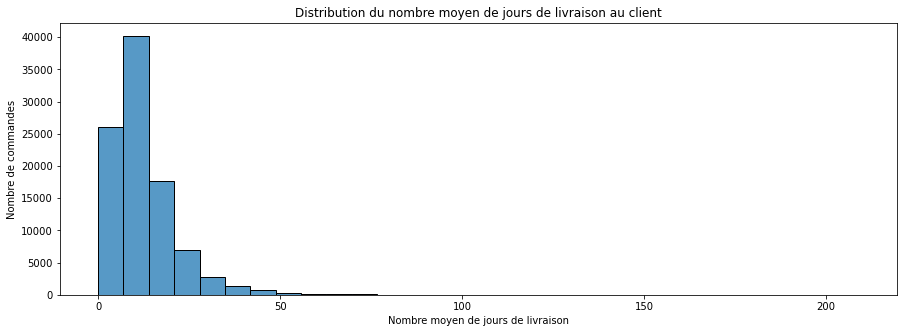

In [55]:
ods_full['int_ord_cus'] = ods_full['ord_cus'].dt.days
plt.figure(figsize=(15, 5))
sns.histplot(data=ods_full, x='int_ord_cus', bins=30)
plt.title("Distribution du nombre moyen de jours de livraison au client")
plt.xlabel("Nombre moyen de jours de livraison")
plt.ylabel("Nombre de commandes")
plt.show()

Statut des commandes non approuvées : ['canceled' 'delivered' 'created']
-----------------------------------


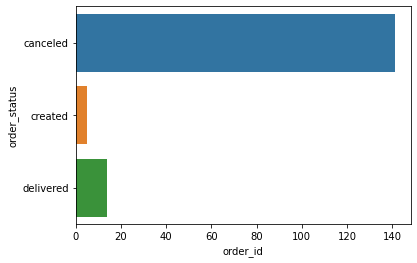

In [56]:
print(f"Statut des commandes non approuvées : {ods.loc[ods['order_approved_at'].isna(), 'order_status'].unique()}")
print("-----------------------------------")
non_appr = ods.loc[ods['order_approved_at'].isna()].groupby('order_status').count().reset_index()
sns.barplot(data=non_appr, x='order_id', y='order_status')
plt.show()

Statut des commandes non livrées au transporteur : ['invoiced' 'processing' 'unavailable' 'canceled' 'created' 'approved'
 'delivered']
------------------------------------------------


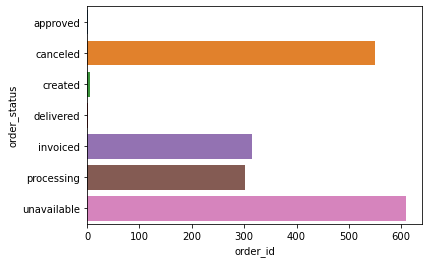

In [57]:
print(f"Statut des commandes non livrées au transporteur : {ods.loc[ods['order_delivered_carrier_date'].isna(), 'order_status'].unique()}")
print("------------------------------------------------")
non_car = ods.loc[ods['order_delivered_carrier_date'].isna()].groupby('order_status').count().reset_index()
sns.barplot(data=non_car, x='order_id', y='order_status')
plt.show()

Statut des commandes non livrées au client : ['invoiced' 'shipped' 'processing' 'unavailable' 'canceled' 'delivered'
 'created' 'approved']
------------------------------------------


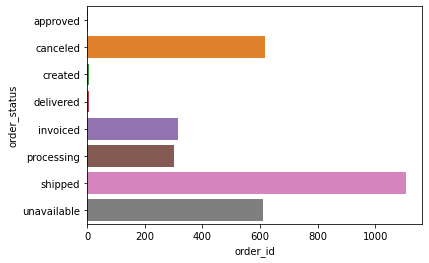

In [58]:
print(f"Statut des commandes non livrées au client : {ods.loc[ods['order_delivered_customer_date'].isna(), 'order_status'].unique()}")
print("------------------------------------------")
non_cus = ods.loc[ods['order_delivered_customer_date'].isna()].groupby('order_status').count().reset_index()
sns.barplot(data=non_cus, x='order_id', y='order_status')
plt.show()

In [13]:
cus_ods = pd.merge(cus, ods, how='left', on='customer_id')
cus_ods.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,nb_orders,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05


In [14]:
cus_ods['late_delivery'] = cus_ods.apply(lambda x: x['order_delivered_customer_date'] > x['order_estimated_delivery_date'], axis=1)
cus_ods['late_delivery'] = cus_ods['late_delivery'].astype('int')

Influence du retard de livraison sur le nombre de commandes passées par un client
---------------------------------------------------------------------------------


<AxesSubplot:>

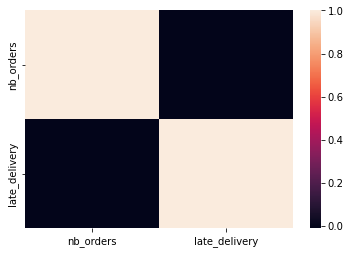

In [61]:
print("Influence du retard de livraison sur le nombre de commandes passées par un client")
print('---------------------------------------------------------------------------------')
sns.heatmap(cus_ods[['nb_orders', 'late_delivery']].corr())

In [15]:
cus_ods['shipment_delay'] = cus_ods['order_delivered_customer_date'] - cus_ods['order_purchase_timestamp']
cus_ods['shipment_delay'] = cus_ods['shipment_delay'].dt.days

Influence du nombre de jours de livraison sur le nombre de commandes passées par un client
------------------------------------------------------------------------------------------


<AxesSubplot:>

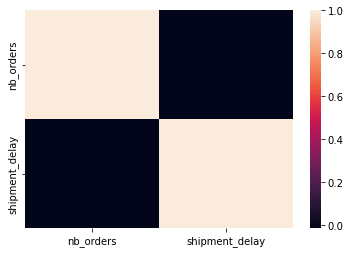

In [63]:
print("Influence du nombre de jours de livraison sur le nombre de commandes passées par un client")
print('------------------------------------------------------------------------------------------')
sns.heatmap(cus_ods[['nb_orders', 'shipment_delay']].corr())

In [64]:
ods['purchase_month_year'] = ods.apply(
    lambda x: f"{int(x['order_purchase_timestamp'].month)}-{int(x['order_purchase_timestamp'].year)}",
    axis=1)

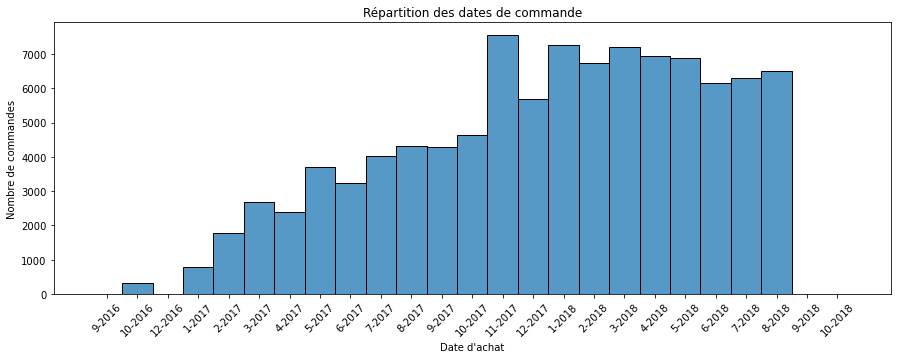

In [65]:
plt.figure(figsize=(15,5))
sns.histplot(data=ods.sort_values(by='order_purchase_timestamp'), x='purchase_month_year')
plt.title(f"Répartition des dates de commande")
plt.xlabel("Date d'achat")
plt.ylabel("Nombre de commandes")
plt.xticks(rotation=45)
plt.show()

In [194]:
ods.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_recence,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-381,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-85,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-71,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-333,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-246,-10.0


In [205]:
ods_grouped = ods[ods['order_purchase_timestamp'].dt.year >= 2018]
ods_grouped = ods_grouped.groupby(ods_grouped.order_purchase_timestamp.dt.month)['order_id'].count().reset_index()
ods_grouped = ods_grouped[ods_grouped['order_purchase_timestamp'] < 9]
ods_grouped

,order_purchase_timestamp,order_id
0,1,7269
1,2,6728
2,3,7211
3,4,6939
4,5,6873
5,6,6167
6,7,6292
7,8,6512


In [206]:
print(f"Nombre moyen de commandes passées entre janvier et août 2018 : {ods_grouped['order_id'].mean()}")
print("------------------------------------------------------------")

Nombre moyen de commandes passées entre janvier et août 2018 : 6748.875
------------------------------------------------------------


In [66]:
print("10 meilleurs mois de vente")
print('--------------------------')
ods.groupby('purchase_month_year').count().sort_values('order_id', ascending=False).loc[:,['order_id']].head(10)

10 meilleurs mois de vente
--------------------------


,order_id
purchase_month_year,
11-2017,7544
1-2018,7269
3-2018,7211
4-2018,6939
5-2018,6873
2-2018,6728
8-2018,6512
7-2018,6292
6-2018,6167


<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Orders</b><br>

**Valeurs manquantes**
    
Les valeurs manquantes sont, à 14 exceptions près, légitimes : il s'agit de commandes n'ayant pas été approuvée ni/ou livrées :
- Les commandes sans approbation sont soit annulées soit juste crées
- Les commandes non livrées peuvent avoir tous types de statut, majoritairement 'annulé' ou 'indisponible'

Les 14 commandes n'ayant pas de date de livraison mais un statut 'livré' sont de vraies valeurs manquantes qu'il faudra traiter<br><br>
    
**Outliers**
    
Les possibles outliers sont à chercher dans l'ordre des dates pour chaque commande. En effet, la procédure de commande se déroule en principe de la manière suivante :
    
<img src="img/order_prc.png" style="width: 600px">
    
Or il se trouve que certaines commandes transgressent cet ordre :
- Il arrive fréquemment que l'approbation intervienne après les autres étapes, et bien que ce ne soit pas une bonne chose d'un point de vue des procédures, il n'y a rien d'impossible
- On constate également des livraison client avant livraison transporteur et des livraisons transporteur avant achat --> ici il pourrait s'agir soit de produits déjà présents chez le transporteur au moment de la commande (issus d'une précédente commande annulée par exemple), soit de véritables outliers ; pour le vérifier, il faut avoir accès à la liste des articles associés aux commandes<br><br>
    
**Corrélations**
    
Plusieurs commandes sont arrivées en retard par rapport à la date de livraison estimée, mais il ne semble pas y avoir de corrélation entre ces retards et la propention des clients à placer des commandes subséquentes.<br><br>
    
**Informations métier**
    
Les délais du process de commande chez Olist montrent les délais suivants, pour un total cumulé de 12 jours et demi :
- 10h de temps d'approbation de la commande
- 3 jours d'acheminement jusqu'au transporteur
- 9 jours de livraison du transporteur au client
    
Concernant les livraisons :
- 3% des commandes n'arrivent pas jusqu'au client
- 8% des commandes sont livrées en retard, malgré un délai estimatif de livraison de 23 jours (contre 12 jours et demi de délais moyen de livraison effective)

Concernant les ventes : après une activité sans doute en création durant l'année 2017, marqué par une progression constante du nombre de commande (avec un pic attendu au mois de novembre pour les ventes de Noël), le nombre de commande s'est stabilisé autour de 6000 commandes par mois sur l'ensemble de l'année 2018.
    
</div>

## <div id="ch3_4" style="color: orange;">3.4 Reviews</div>

In [67]:
rev.shape

(99224, 7)

In [68]:
rev.describe(include='all')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


In [69]:
rev.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


<AxesSubplot:>

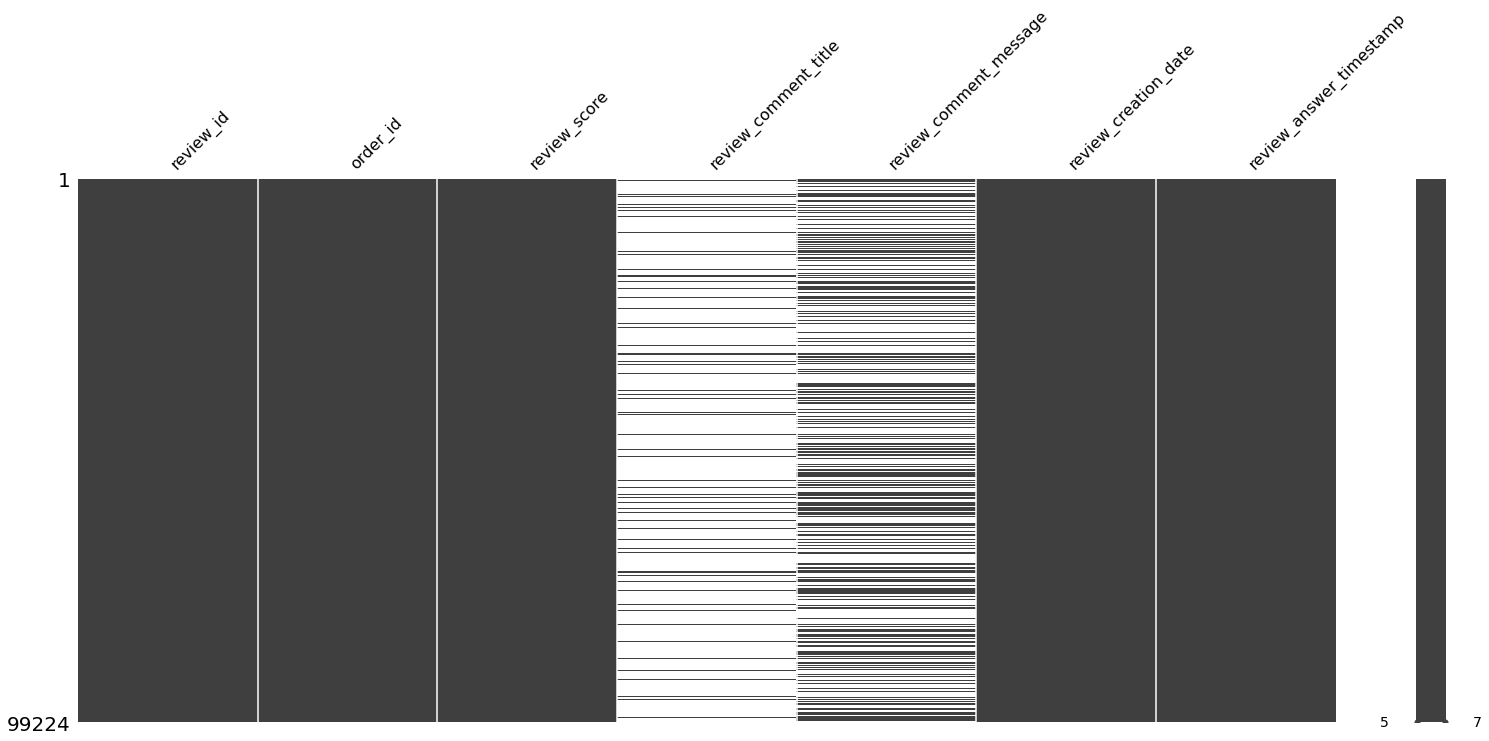

In [70]:
msno.matrix(rev)

In [71]:
(rev.isna().sum()/rev.shape[0]).sort_values(ascending=False)

review_comment_title       0.883415
review_comment_message     0.587025
review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_creation_date       0.000000
review_answer_timestamp    0.000000
dtype: float64

In [72]:
rev.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [16]:
rev_dte = ['review_creation_date', 'review_answer_timestamp']
for c in rev_dte:
    rev[c] = rev[c].astype('datetime64')
rev.dtypes

review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object

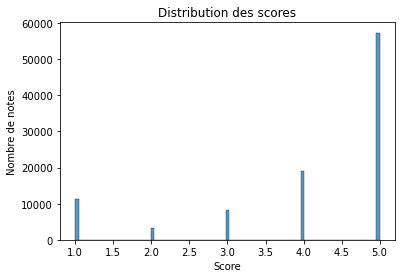

In [74]:
plt.figure()
sns.histplot(rev['review_score'])
plt.title('Distribution des scores')
plt.xlabel('Score')
plt.ylabel('Nombre de notes')
plt.show()

In [75]:
rev['answering_span'] = rev['review_answer_timestamp'] - rev['review_creation_date']
print(f"Temps moyen de réponse à l'enquête de satisfaction : {rev['answering_span'].mean()}")
print(f"Proportion de notes à 1 : {np.round((len(rev[rev['review_score'] == 1]) / len(rev)) * 100, 1)}%")
print(f"Proportion de notes à 5 : {np.round((len(rev[rev['review_score'] == 5]) / len(rev)) * 100, 1)}%")

Temps moyen de réponse à l'enquête de satisfaction : 3 days 03:34:33.029700475
Proportion de notes à 1 : 11.5%
Proportion de notes à 5 : 57.8%


Détection de la langue des commentaires : nous réutilisons ici l'interface web de détection de la langue créée lors du projet 1.

In [76]:
rev.loc[4, 'review_comment_message']

'Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa'

<img src="img/language_detection.png" style="height: 300px">

Normalisation du texte :

- Enlèvement de la ponctuation
- Alignement de la casse
- Enlèvement des mots de liaison
- Lemmatisation des mots significatifs

In [77]:
#Source : https://www.analyticsvidhya.com/blog/2021/09/creating-a-movie-reviews-classifier-using-tf-idf-in-python/
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
from nltk.stem import WordNetLemmatizer
import re
import string

In [78]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aledo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aledo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aledo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [79]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [80]:
lemmatizer = WordNetLemmatizer()

In [81]:
def normalize_text(s):
    s = re.sub('[^a-zA-Z]', ' ', s)
    s = s.lower()
    s = s.split()
    s = [lemmatizer.lemmatize(word) for word in s if not word in set(stopwords)]
    s = ' '.join(s)
    return s

In [82]:
rev_cmt = rev.loc[~rev['review_comment_message'].isna(), ['review_comment_message', 'review_score']]
print(f"Taille du jeu `commentaires + scores` : {rev_cmt.shape}")
rev_cmt.head()

Taille du jeu `commentaires + scores` : (40977, 2)


,review_comment_message,review_score
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5
9,aparelho eficiente. no site a marca do aparelh...,4
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
15,"Vendedor confiável, produto ok e entrega antes...",5


In [83]:
rev_cmt['review_comment_message'] = rev_cmt['review_comment_message'].apply(normalize_text)
rev_cmt.head()

,review_comment_message,review_score
3,recebi bem ante prazo estipulado,5
4,parab n lojas lannister adorei comprar interne...,5
9,aparelho eficiente site marca aparelho impress...,4
12,pouco travando valor ta boa,4
15,vendedor confi vel produto ok entrega ante prazo,5


Le vocable permet-il d'effectuer une classification des scores en fonction des commentaires ?

In [84]:
X_train, X_test, y_train, y_test = train_test_split(rev_cmt['review_comment_message'], rev_cmt['review_score'],
                                                    test_size=0.2)
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_train_tf.shape

(32781, 12333)

In [85]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)
X_test_tf = tf_idf.transform(X_test)
y_pred = naive_bayes_classifier.predict(X_test_tf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.85      0.72      1757
           2       0.00      0.00      0.00       442
           3       0.48      0.02      0.03       696
           4       0.39      0.04      0.07      1161
           5       0.71      0.96      0.81      4140

    accuracy                           0.67      8196
   macro avg       0.44      0.37      0.33      8196
weighted avg       0.58      0.67      0.58      8196



C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
metrics.confusion_matrix(y_test, y_pred)

array([[1489,    0,    2,    3,  263],
       [ 291,    0,    1,   18,  132],
       [ 327,    0,   11,   24,  334],
       [ 174,    0,    5,   46,  936],
       [ 123,    0,    4,   28, 3985]], dtype=int64)

De cette étude, il ressort que le vocable utilsé permet de prédire très efficacement les scores extrêmes (1 et 5).

Nous pouvons donc regarder plus attentivement les mots les plus fréquents pour ces scores afin de déterminer ce qui plaît le plus ou au contraire le moins aux clients ayant mis ces notes.

In [87]:
rev_cmt_1 = rev_cmt.loc[rev_cmt['review_score'] == 1, 'review_comment_message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(rev_cmt_1)
wd_matrix_1 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).transpose().sum(axis=1).sort_values(ascending=False)
print(f"Nombre de mots uniques identifiés : {len(wd_matrix_1)}")
wd_matrix_1.head(20)

C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Nombre de mots uniques identifiés : 7811


produto      5081
recebi       2784
comprei      1560
ainda        1181
veio         1121
entregue     1113
entrega      1082
at           1048
dia          1006
chegou        944
nao           821
compra        763
prazo         702
pedido        657
loja          635
agora         631
nada          475
lannister     471
quero         467
est           463
dtype: int64

Les mots les plus courants dans les réponses négatives sont : `produit`, `reçu`, `acheté`, `toujours`, `arrivé`, `livré`, `livraison`, `à`, `journée`, `est arrivé`, `ne pas`, `achat`, `délais`, `demande`, `boutique`, `à présent`, `rien`, `veux`, `est`.

Au-delà des mots de liaison que notre lemmatisation n'a pas su identifier, on constate que la grande majorité des mots les plus courants parmis les mauvais scores sont liés à la <b>livraison</b> et aux <b>délais</b>, qui ressortent comme les deux grands irritants des clients insatisfaits.

In [88]:
rev_cmt_5 = rev_cmt.loc[rev_cmt['review_score'] == 5, 'review_comment_message']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(rev_cmt_5)
wd_matrix_1 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).transpose().sum(axis=1).sort_values(ascending=False)
print(f"Nombre de mots uniques identifiés : {len(wd_matrix_1)}")
wd_matrix_1.head(20)

C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Nombre de mots uniques identifiés : 6449


produto      8118
prazo        5703
ante         4538
entrega      3699
recomendo    3328
chegou       3219
bom          2954
bem          2200
qualidade    1756
entregue     1675
tudo         1648
excelente    1624
timo         1544
super        1480
loja         1175
pida         1153
gostei       1052
recebi       1049
compra        876
parab         849
dtype: int64

Les mots les plus courants dans les réponses positives sont : `produit`, `délais`, `avant que`, `livraison`, `recommande`, `arrivé`, `bien`, `bon`, `qualité`, `livré`, `tout`, `excellent`, `super`, `boutique`, `aimé`, `reçu`, `achat`, `félicitation`.

Les deux champs lexicaux qui ressortent des commentaires positifs sont liés à la <b>livraison</b> et à la <b>qualité</b> des produits.

Fusionnons à présent ce dataset avec ceux déjà analysés.

In [17]:
rev_cus_ods = pd.merge(rev, cus_ods, how='left', on='order_id')

In [18]:
geo_uniq = geo.drop_duplicates(['geolocation_zip_code_prefix'], keep='first')

In [19]:
rcog = pd.merge(rev_cus_ods, geo_uniq, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

In [92]:
rcog.shape

(99224, 27)

In [93]:
rcog.head(1)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,answering_span,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,nb_orders,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,late_delivery,shipment_delay,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59,0 days 21:46:59,41dcb106f807e993532d446263290104,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,1,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02,0,6.0,6030.0,-23.561963,-46.765487,osasco,SP


In [94]:
print("Recherche d'incohérences sur la date")
print("------------------------------------")
print()
print(f"Réponse avant création de la review : {len(rev[rev['review_answer_timestamp'] < rev['review_creation_date']])}")
print(f"Réponse avant achat : {len(rcog[rcog['review_answer_timestamp'] < rcog['order_purchase_timestamp']])}")
print(f"Réponse avant livraison transporteur : {len(rcog[rcog['review_answer_timestamp'] < rcog['order_delivered_carrier_date']])}")
print(f"Réponse avant livraison client : {len(rcog[rcog['review_answer_timestamp'] < rcog['order_delivered_customer_date']])}")

Recherche d'incohérences sur la date
------------------------------------

Réponse avant création de la review : 0
Réponse avant achat : 63
Réponse avant livraison transporteur : 226
Réponse avant livraison client : 4795


In [20]:
scores_st = rcog[['customer_state', 'review_score']].groupby('customer_state').agg(['mean', 'median', 'count'])
scores_st = scores_st.droplevel(level=0, axis=1).reset_index()
scores_st = pd.merge(scores_st, geo[['geolocation_state', 'geolocation_lat', 'geolocation_lng']].drop_duplicates(
    subset='geolocation_state'), how='left', left_on='customer_state', right_on='geolocation_state').drop(
    'geolocation_state', axis=1)
scores_st.head()

,customer_state,mean,median,count,geolocation_lat,geolocation_lng
0,AC,4.049383,5.0,81,-23.578707,-46.645779
1,AL,3.751208,4.0,414,-9.590207,-35.766997
2,AM,4.183673,5.0,147,-3.098469,-59.999784
3,AP,4.194030,5.0,67,0.040253,-51.078577
4,BA,3.860888,4.0,3357,-12.987172,-38.522682


In [23]:
print("Note médiane par Etat :")
print()
states = rcog['customer_state'].unique()
m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=(-19.5, -54.39), zoom=3)
for s in states:
    row = scores_st[scores_st['customer_state'] == s]
    icon = Icon(icon_url=f"img/score_{int(row['median'])}.png")
    marker = Marker(location=(float(row['geolocation_lat']), float(row['geolocation_lng'])), opacity=0.8, icon=icon,
                   title=f"Etat {s} :: Note médiane {int(row['median'])} :: Note moyenne {np.round(float(row['mean']), 1)}")
    m.add_layer(marker)
m

Note médiane par Etat :



Map(center=[-19.5, -54.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

<img src="img/leaf_median_rev_score.png">

In [24]:
print("Localisation des clients ayant voté 1 dans les Etats dont le nombre des scores à 1 est supérieur à la moyenne :")
print()
states = rcog['customer_state'].unique()
m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=(-19.5, -54.39), zoom=3)
for s in states:
    rcog_st = rcog[rcog['customer_state'] == s]
    bad_mean = len(rcog_st[rcog_st['review_score'] == 1]) / len(rcog_st)
    if bad_mean > 0.115:
        markers = [Marker(location=(r['geolocation_lat'], r['geolocation_lng'])) 
                   for idx, r in rcog[(rcog['review_score'] == 1) & (rcog['customer_state'] == s)].iterrows()]
        cluster = MarkerCluster(markers=tuple(markers))
        m.add_layer(cluster)
m

Localisation des clients ayant voté 1 dans les Etats dont le nombre des scores à 1 est supérieur à la moyenne :



C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Map(center=[-19.5, -54.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

<img src="img/leaf_rev_score_1.png">

In [185]:
print("Localisation des clients ayant voté 5 dans les Etats dont le nombre des scores à 5 est supérieur à la moyenne :")
print()
states = rcog['customer_state'].unique()
m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=(-19.5, -54.39), zoom=3)
for s in states:
    rcog_st = rcog[rcog['customer_state'] == s]
    good_mean = len(rcog_st[rcog_st['review_score'] == 5]) / len(rcog_st)
    if good_mean > 0.578:
        markers = [Marker(location=(r['geolocation_lat'], r['geolocation_lng'])) 
                   for idx, r in rcog[(rcog['review_score'] == 5) & (rcog['customer_state'] == s)].iterrows()]
        cluster = MarkerCluster(markers=tuple(markers))
        m.add_layer(cluster)
m

Localisation des clients ayant voté 5 dans les Etats dont le nombre des scores à 5 est supérieur à la moyenne :



C:\Users\aledo\anaconda3\envs\p5\lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Map(center=[-19.5, -54.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

<img src="img/leaf_rev_score_5.png">

In [21]:
rcog[['review_score', 'nb_orders']].corr()

,review_score,nb_orders
review_score,1.00000,0.01301
nb_orders,0.01301,1.00000


<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Review</b><br>

**Valeurs manquantes**
    
Les valeurs manquantes se retrouvent uniquement dans les commentaires et leurs titres : les autres données sont disponibles pour toutes les lignes du dataset.<br><br>

**Scores**
    
Les scores sont représentés par une note entre 1 (minimum) et 5 (maximum). La note médiane (5) et la note moyenne (4,09) sont bonnes et semblent annoncer une bonne satisfaction globale des services Olist. Cependant, si la note 5 est largement majoritaire (57,8% des enquêtes relevées), la proportion de note à 1 (11,5%) est loin d'être négligeable.
    
En observant la répartition des scores sur le territoire, on s'aperçoit que les notes faibles se trouvent proportionellement plus concentrées au Nord-Est, au niveau de la "corne" du Brésil autour de *Recife*, tandis que les notes les plus élevées sont plus concentrées au Sud-Est du pays, près de *São Paulo*.
    
    
Par ailleurs, on remarque que la densité de bonnes évaluations est la plus importante là où les clients ont placé plusieurs commandes, bien qu'il ne semble pas y avoir de corrélation linéraire entre ces deux variables.<br><br>
    
**Commentaires**
    
En observant plus attentivement les commentaires, nous pouvons observer deux choses :
- La qualité des produits est souvent saluée par les clients
- Le process de livraison est à la fois une force et une faiblesse pour Olist, étant parmi les éléments à la fois plébiscités et décriés par les clients. Etant donné la répartition des notes, on peut supposer qu'Olist devrait en priorité travailler sur ses contrats transporteurs afin d'améliorer la satisfaction de ses clients, notament en diminuant les fortes variations de délais de livraison.<br><br>
    
**Outliers**
    
Il y a de potentiels outliers au niveau des dates de réponse aux enquêtes. En effet, selon ces dernières, les clients auraient pu répondre aux enquêtes de satisfaction avant d'avoir été livré du produit, voire même dans certains cas avant de l'avoir acheté !<br><br>
    
**Information supplémentaire**
    
Le délais moyen de réponse aux enquêtes de satisfaction et d'environ 3 jours après son ouverture.
    
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch3_5" style="color: orange;">3.5 Payments</div>

<div class="alert alert-block alert-info">
    <b><u>Cours du Réal brésilien 2017-2018</u> : </b> 1 BRL = 0.25 EUR<br>
</div>

In [22]:
pay.shape

(103886, 5)

In [23]:
pay.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


In [24]:
pay.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


<AxesSubplot:>

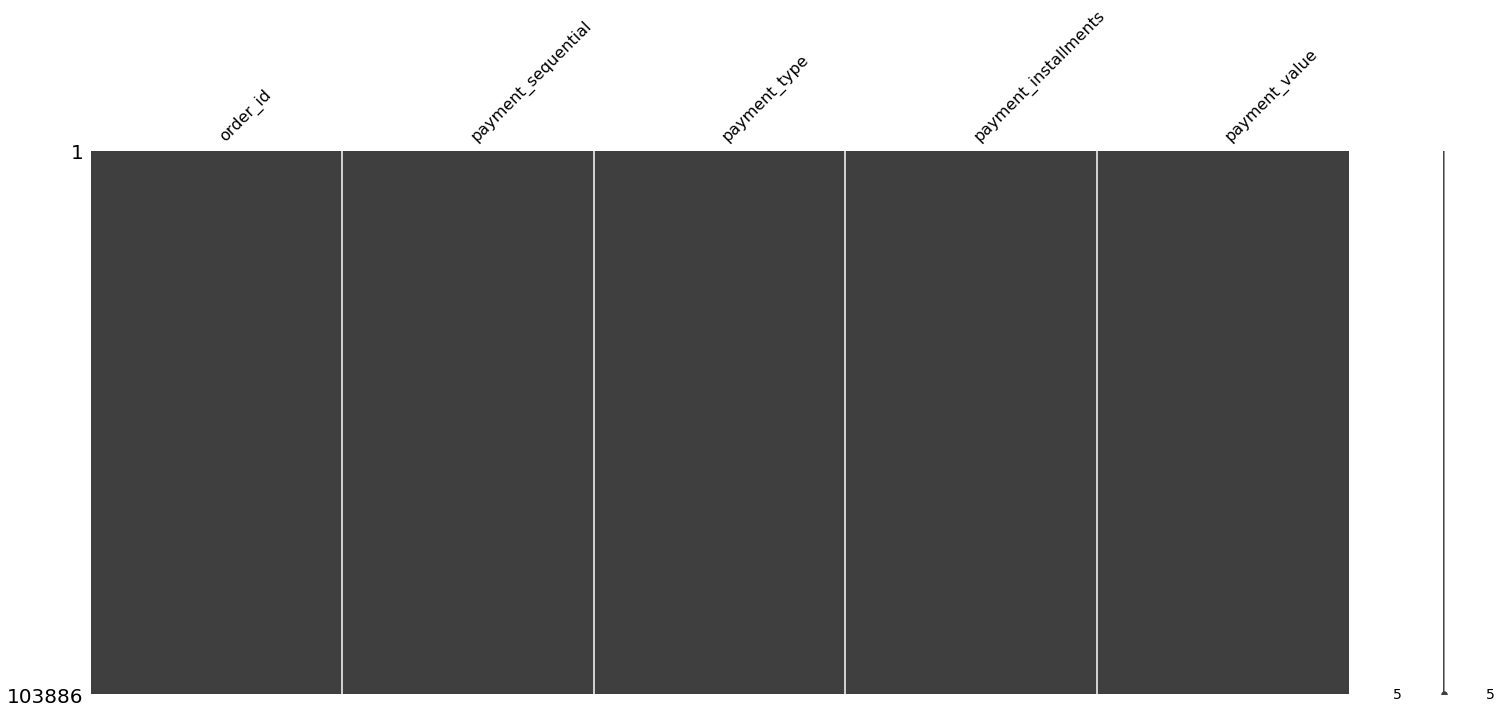

In [25]:
msno.matrix(pay)

In [26]:
(pay.isna().sum()/pay.shape[0]).sort_values(ascending=False)

order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

In [27]:
pay_type = pay.loc[:, ['payment_type']]
pay_quanti = pay.select_dtypes(include=np.number)

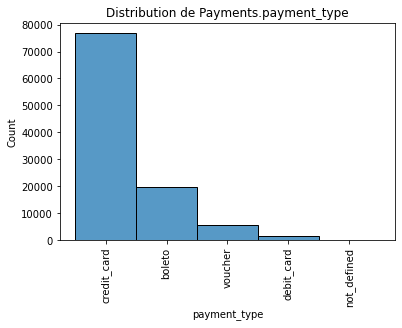

In [28]:
display_distri(pay_type, dataset_name='Payments', quali=True)

In [213]:
pay.groupby('payment_type').count().reset_index().loc[:, ['payment_type', 'order_id']].sort_values(by='order_id', ascending=False)

,payment_type,order_id
1,credit_card,76795
0,boleto,19784
4,voucher,5775
2,debit_card,1529
3,not_defined,3


In [29]:
print(f"Proportion des paiements effecués en carte : {np.round((len(pay[pay['payment_type'] == 'credit_card']) / len(pay)) * 100)}%")
print(f"Proportion des paiements effecués en espèces : {np.round((len(pay[pay['payment_type'] == 'boleto']) / len(pay)) * 100)}%")

Proportion des paiements effecués en carte : 74.0%
Proportion des paiements effecués en espèces : 19.0%


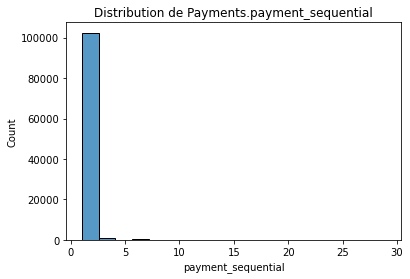

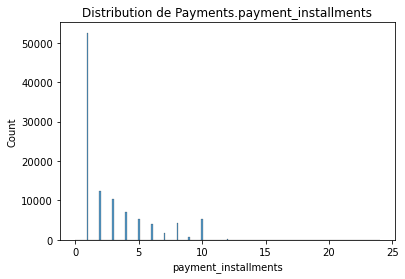

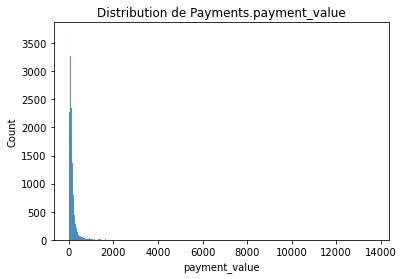

In [30]:
display_distri(pay_quanti, dataset_name='Payments')

Corrélations linéraires des variables quantitatives
---------------------------------------------------



<AxesSubplot:>

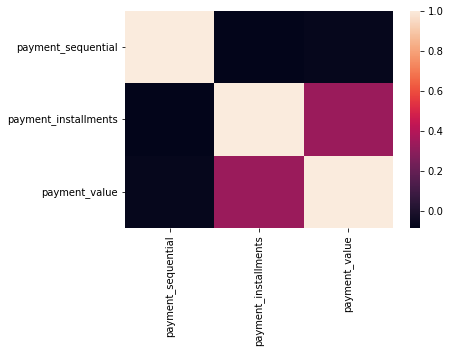

In [31]:
print("Corrélations linéraires des variables quantitatives")
print("---------------------------------------------------")
print()
sns.heatmap(pay_quanti.corr())

Nombre de fragmentations du paiement en fonction du montant de la commande
--------------------------------------------------------------------------



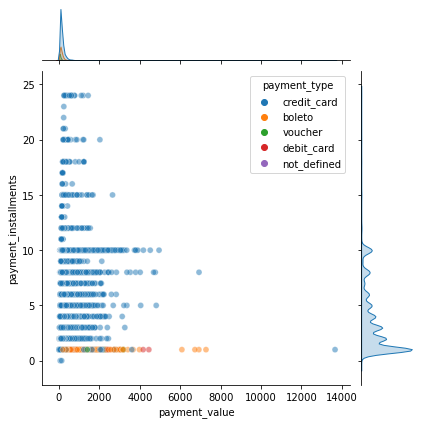

In [32]:
print('Nombre de fragmentations du paiement en fonction du montant de la commande')
print('--------------------------------------------------------------------------')
print()
sns.jointplot(data=pay, x='payment_value', y='payment_installments', hue='payment_type', alpha=0.5)

In [33]:
print(f"Nombre de paiements en plusieurs mensualités effectués avec un autre moyen de paiement que la carte de crédit : {len(pay[(pay['payment_installments'] > 1) & (pay['payment_type'] != 'credit_card')])}")

Nombre de paiements en plusieurs mensualités effectués avec un autre moyen de paiement que la carte de crédit : 0


In [34]:
print("Classement par ordre décroissant de montants de commandes")
print("---------------------------------------------------------")
print()
pay.sort_values(by='payment_value', ascending=False).head(10)

Classement par ordre décroissant de montants de commandes
---------------------------------------------------------



,order_id,payment_sequential,payment_type,payment_installments,payment_value
52107,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08
34370,736e1922ae60d0d6a89247b851902527,1,boleto,1,7274.88
41419,0812eb902a67711a1cb742b3cdaa65ae,1,credit_card,8,6929.31
49581,fefacc66af859508bf1a7934eab1e97f,1,boleto,1,6922.21
85539,f5136e38d1a14a4dbd87dff67da82701,1,boleto,1,6726.66
62409,2cc9089445046817a7539d90805e6e5a,1,boleto,1,6081.54
43232,a96610ab360d42a2e5335a3998b4718a,1,credit_card,10,4950.34
70320,b4c4b76c642808cbe472a32b86cddc95,1,credit_card,5,4809.44
6440,199af31afc78c699f0dbf71fb178d4d4,1,credit_card,8,4764.34
67546,8dbc85d1447242f3b127dda390d56e19,1,credit_card,8,4681.78


In [35]:
print("Classement par ordre décroissant de montants de commandes payées en espèce")
print("--------------------------------------------------------------------------")
print()
pay[pay['payment_type'] == 'boleto'].sort_values(by='payment_value', ascending=False).head(10)

Classement par ordre décroissant de montants de commandes payées en espèce
--------------------------------------------------------------------------



,order_id,payment_sequential,payment_type,payment_installments,payment_value
34370,736e1922ae60d0d6a89247b851902527,1,boleto,1,7274.88
49581,fefacc66af859508bf1a7934eab1e97f,1,boleto,1,6922.21
85539,f5136e38d1a14a4dbd87dff67da82701,1,boleto,1,6726.66
62409,2cc9089445046817a7539d90805e6e5a,1,boleto,1,6081.54
5279,41b7766bb1df487d17fb9725b78ff509,1,boleto,1,3979.55
34145,b15c7e972c74684414fb2e659fce916a,1,boleto,1,3666.42
64064,43bdbd9dc0931d72befdf4765af6c442,1,boleto,1,3406.47
79085,4412d97cb2093633afa85f11db46316c,1,boleto,1,3195.73
80284,31e50461be6957a749166e97af082d0a,1,boleto,1,3155.82
50858,52e6988a13f9dd7d567b0816dba52a03,1,boleto,1,3041.73


In [36]:
print(f"Nombre de paiement en espèce > 1000 : {len(pay[(pay['payment_type'] == 'boleto') & (pay['payment_value'] > 1000)])}")

Nombre de paiement en espèce > 1000 : 178


In [37]:
print("Classement par ordre décroissant de nombre de mensualités")
print("---------------------------------------------------------")
print()
pay.sort_values(by='payment_installments', ascending=False).head(10)

Classement par ordre décroissant de nombre de mensualités
---------------------------------------------------------



,order_id,payment_sequential,payment_type,payment_installments,payment_value
60027,ef71772d55431467890fda2f45c7bdde,1,credit_card,24,629.64
55094,fcbb6af360b31b05460c2c8e524588c0,1,credit_card,24,1194.38
21713,6ae2e8b8fac02522481d2a2f4ca4412c,1,credit_card,24,433.43
50401,ffb18bf111fa70edf316eb0390427986,1,credit_card,24,617.24
2970,70b7e94ea46d3e8b5bc12a50186edaf0,1,credit_card,24,274.84
90639,d74fca7ee2ce7587c45eefb0fea95ed8,1,credit_card,24,1099.00
102435,e02d61b42452cc6737650331d8bc8ad7,1,credit_card,24,515.70
63893,d8d5cc8b2d42cce90b7ea35e5691a7b1,1,credit_card,24,599.18
10791,859f516f2fc3f95772e63c5757ab0d5b,1,credit_card,24,609.56
36088,84d2098c97827c6327ed4d7be95e1fc8,1,credit_card,24,286.78


In [218]:
pay_grouped = pay.groupby('order_id').max().reset_index().loc[:, ['order_id', 'payment_installments']]
print(f"Proportion de commandes payées en plusieurs fois : {np.round((len(pay_grouped[pay_grouped['payment_installments'] > 1]) / len(pay_grouped)) * 100, 1)}%")

Proportion de commandes payées en plusieurs fois : 51.5%


<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Payments</b><br>
    
**Outliers**
    
Les paiments en cash pour des achats online peuvent paraître surprenants d'un point de vue européen, mais sont effectivement autorisés au Brésil, comme le confirme [cette étude de JP Morgan](https://www.jpmorgan.com/merchant-services/insights/reports/brazil). De plus, contrairement à la France ou des limites strictes de paiement en cash pour un même transaction existent (1000€ pour les citoyens français, 3000€ pour les étrangers et les entreprises); ce genre de limite n'existe pas au Brésil.
    
En revanche, on peut remarquer un paiement surprenant de 13 664 BRL (Brasilian ReaL, au taux de 1€ = 5,26 BRL au 4 mai 2022 - [XE.com](https://www.xe.com/fr/currencyconverter/convert/?Amount=1&From=EUR&To=BRL), soit 2 594€), effectué en une seule fois. Il faudra vérifier dans les tables suivantes quels sont les produits rattachés à cette commande.<br><br>
    
**Information métier**
    
Il y a une corrélation ténue entre le montant du paiement et le nombre de mensualités (le paiement en plusieurs fois n'étant disponibles qu'aux clients payant en carte), mais cette relation est surprenante : plus le nombre de mensualité est élevé, moins le montant est élevé.
    
    
On remarque que :
- Les 3/4 des transactions s'effectuent en carte de crédit
- 1 transaction sur 5 est effectuée en cash
- 1 transaction sur 2 fait l'objet d'un paiement en plusieurs fois
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch3_6" style="color: orange;">3.6 Items</div>

In [38]:
itm.shape

(112650, 7)

In [39]:
itm.describe(include='all')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


In [40]:
itm.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


<AxesSubplot:>

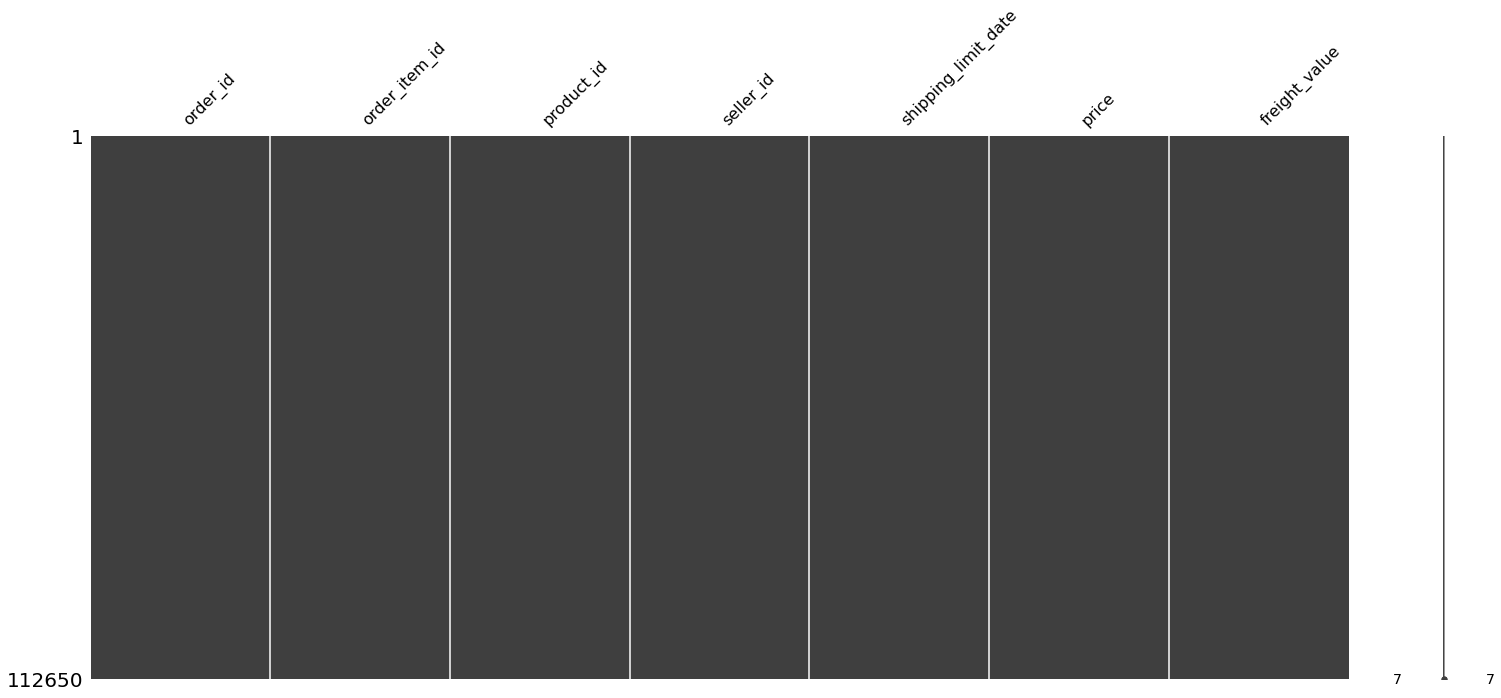

In [41]:
msno.matrix(itm)

In [42]:
(itm.isna().sum()/itm.shape[0]).sort_values(ascending=False)

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [43]:
itm_quanti = itm.loc[:, ['order_item_id', 'price', 'freight_value']]

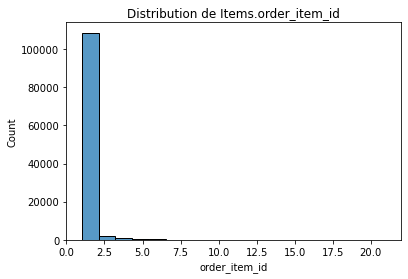

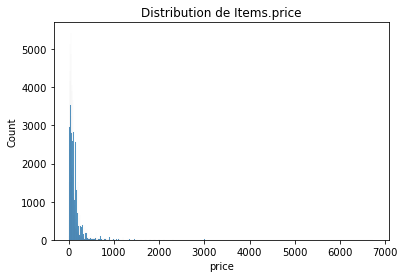

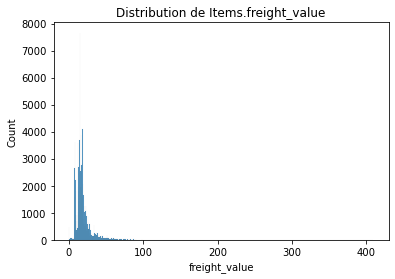

In [44]:
display_distri(itm_quanti, dataset_name='Items')

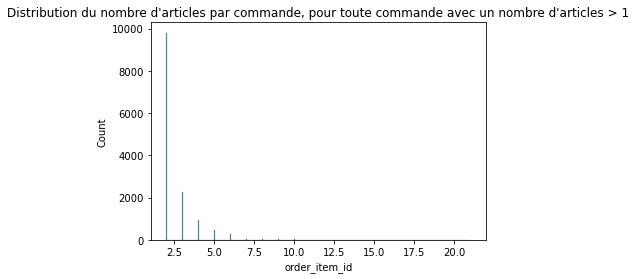

In [45]:
plt.figure()
sns.histplot(itm.loc[itm['order_item_id'] > 1, 'order_item_id'])
plt.title("Distribution du nombre d'articles par commande, pour toute commande avec un nombre d'articles > 1")
plt.show()

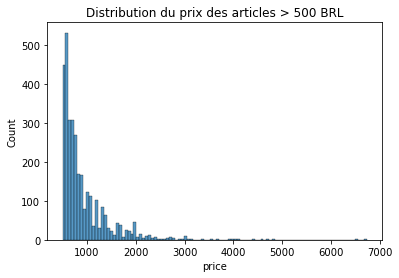

In [46]:
plt.figure()
sns.histplot(itm.loc[itm['price'] > 500, 'price'])
plt.title("Distribution du prix des articles > 500 BRL")
plt.show()

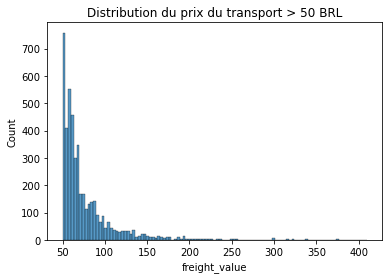

In [47]:
plt.figure()
sns.histplot(itm.loc[itm['freight_value'] > 50, 'freight_value'])
plt.title("Distribution du prix du transport > 50 BRL")
plt.show()

Corrélations linéaires sur les variables quantitatives
------------------------------------------------------


<AxesSubplot:>

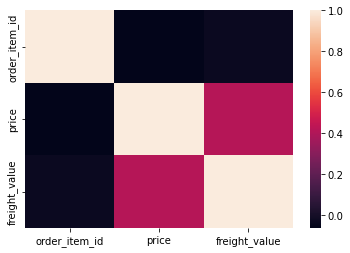

In [48]:
print('Corrélations linéaires sur les variables quantitatives')
print('------------------------------------------------------')
sns.heatmap(itm_quanti.corr())

Prix du transport en fonction du prix de l'article
--------------------------------------------------


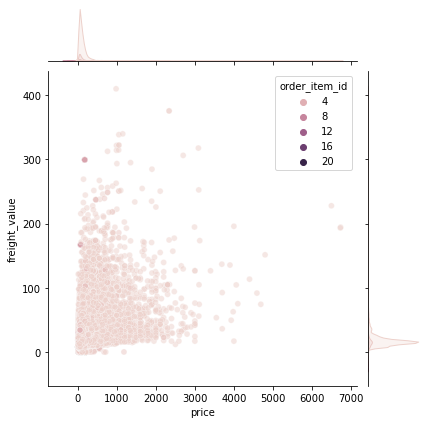

In [49]:
print("Prix du transport en fonction du prix de l'article")
print('--------------------------------------------------')
sns.jointplot(data=itm, x='price', y='freight_value', hue='order_item_id', alpha=0.5)

In [50]:
print("Items triés par valeurs de transport descendant")
print('-----------------------------------------------')
itm.sort_values(by='freight_value', ascending=False).head(10)

Items triés par valeurs de transport descendant
-----------------------------------------------


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
73486,a77e1550db865202c56b19ddc6dc4d53,1,ec31d2a17b299511e7c8627be9337b9b,257e61d3251fb5efb9daadddbc2cf7ca,2018-04-25 06:55:13,979.00,409.68
28044,3fde74c28a3d5d618c00f26d51baafa0,1,a3cd9517ebf5a50dca25acce54f3b171,6fa9202c10491e472dffd59a3e82b2a3,2018-08-22 03:15:09,2338.08,375.28
3303,076d1555fb53a89b0ef4d529e527a0f6,1,a3cd9517ebf5a50dca25acce54f3b171,6fa9202c10491e472dffd59a3e82b2a3,2018-08-07 04:35:22,2338.08,375.28
69797,9f49bd16053df810384e793386312674,1,256a9c364b75753b97bee410c9491ad8,5c030029b5916fed0986310385ec9009,2018-08-02 03:44:28,1149.00,339.59
16731,264a7e199467906c0727394df82d1a6a,1,97c948ebc8c04b26b7bbb095d4228f2a,17f51e7198701186712e53a39c564617,2018-04-23 17:15:10,1050.00,338.30
87936,c7a07ddd52bbe18b61da49a8d89853d3,1,97c948ebc8c04b26b7bbb095d4228f2a,17f51e7198701186712e53a39c564617,2018-07-31 10:45:11,1050.00,322.10
5037,0b6230647ed16f4b3e70282dc4b5b87f,1,46e24ce614899e36617e37ea1e4aa6ff,17f51e7198701186712e53a39c564617,2018-06-01 19:14:24,1050.00,321.88
3584,0822bcde10bb5d023755a71bc8f7797f,1,363a9f5b97bf194da23858be722a7aa5,9596c870880d900012f2e8e6e30d06d7,2018-05-10 23:52:39,990.00,321.46
29787,43bdbd9dc0931d72befdf4765af6c442,1,7e53e051875b2a0c9f22acd8a9a29a20,eeb6de78f79159600292e314a77cbd18,2018-07-12 08:35:21,3089.00,317.47
48320,6ddfbf514959b49b6410c01ad93054bb,1,363a9f5b97bf194da23858be722a7aa5,9596c870880d900012f2e8e6e30d06d7,2017-11-30 15:10:57,1045.00,314.40


In [51]:
print("Items triés par prix descendant")
print('-------------------------------')
itm.sort_values(by='price', ascending=False).head(10)

Items triés par prix descendant
-------------------------------


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
3556,0812eb902a67711a1cb742b3cdaa65ae,1,489ae2aa008f021502940f251d4cce7f,e3b4998c7a498169dc7bce44e6bb6277,2017-02-16 20:37:36,6735.00,194.31
112233,fefacc66af859508bf1a7934eab1e97f,1,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,2018-08-02 04:05:13,6729.00,193.21
107841,f5136e38d1a14a4dbd87dff67da82701,1,1bdf5e6731585cf01aa8169c7028d6ad,ee27a8f15b1dded4d213a468ba4eb391,2017-06-15 02:45:17,6499.00,227.66
74336,a96610ab360d42a2e5335a3998b4718a,1,a6492cc69376c469ab6f61d8f44de961,59417c56835dd8e2e72f91f809cd4092,2017-04-18 13:25:18,4799.00,151.34
11249,199af31afc78c699f0dbf71fb178d4d4,1,c3ed642d592594bb648ff4a04cee2747,59417c56835dd8e2e72f91f809cd4092,2017-05-09 15:50:15,4690.00,74.34
62086,8dbc85d1447242f3b127dda390d56e19,1,259037a6a41845e455183f89c5035f18,c72de06d72748d1a0dfb2125be43ba63,2018-06-28 12:36:36,4590.00,91.78
29193,426a9742b533fc6fed17d1fd6d143d7e,1,a1beef8f3992dbd4cd8726796aa69c53,512d298ac2a96d1931b6bd30aa21f61d,2018-08-16 14:24:28,4399.87,113.45
45843,68101694e5c5dc7330c91e1bbc36214f,1,6cdf8fc1d741c76586d8b6b15e9eef30,ed4acab38528488b65a9a9c603ff024a,2018-04-05 08:27:27,4099.99,75.27
78310,b239ca7cd485940b31882363b52e6674,1,dd113cb02b2af9c8e5787e8f1f0722f6,821fb029fc6e495ca4f08a35d51e53a5,2018-08-02 08:15:14,4059.00,104.51
59137,86c4eab1571921a6a6e248ed312f5a5a,1,6902c1962dd19d540807d0ab8fade5c6,fa1c13f2614d7b5c4749cbc52fecda94,2017-03-23 20:08:04,3999.90,17.01


In [52]:
itm_price = itm.groupby('order_id').sum().reset_index().loc[:, ['order_id', 'price', 'freight_value']]
itm_prod = itm.groupby('order_id').max().reset_index().loc[:, ['order_id', 'order_item_id']]
itm_agg = pd.merge(itm_price, itm_prod, how='inner', on='order_id')
itm_agg.head()

,order_id,price,freight_value,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1


In [53]:
pay_agg = pay.groupby('order_id').sum().reset_index().loc[:, ['order_id', 'payment_installments', 'payment_value']]
pay_agg.head()

,order_id,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,2,72.19
1,00018f77f2f0320c557190d7a144bdd3,3,259.83
2,000229ec398224ef6ca0657da4fc703e,5,216.87
3,00024acbcdf0a6daa1e931b038114c75,2,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,3,218.04


In [54]:
print(f"Différence entre la table `Payments` et la table `Items` : {len(pay_agg) - len(itm_agg)}")

Différence entre la table `Payments` et la table `Items` : 774


In [55]:
itm_pay = pd.merge(itm_agg, pay_agg, how='right', on='order_id')
itm_pay['total_paid'] = itm_pay['price'] + itm_pay['freight_value']
itm_pay.head()

,order_id,price,freight_value,order_item_id,payment_installments,payment_value,total_paid
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1.0,2,72.19,72.19
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1.0,3,259.83,259.83
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1.0,5,216.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1.0,2,25.78,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1.0,3,218.04,218.04


In [56]:
itm_pay['payment_value'] = itm_pay['payment_value'].apply(lambda x: truncate(x, 1))
itm_pay['total_paid'].fillna(0, inplace=True)
itm_pay['total_paid'] = itm_pay['total_paid'].apply(lambda x: truncate(x, 1))
print(f"Nombre de lignes avec différence entre `total_paid` et `payment_value` hors NaN : {len(itm_pay[(itm_pay['payment_value'] != itm_pay['total_paid']) & (itm_pay['total_paid'] != 0)])}")
print()
print("Premières lignes avec différence entre les deux totaux")
print("------------------------------------------------------")
itm_pay[(itm_pay['payment_value'] != itm_pay['total_paid']) & (itm_pay['total_paid'] != 0)].head(10)

Nombre de lignes avec différence entre `total_paid` et `payment_value` hors NaN : 763

Premières lignes avec différence entre les deux totaux
------------------------------------------------------


,order_id,price,freight_value,order_item_id,payment_installments,payment_value,total_paid
48,001e7cf2ad6bef3ade12ebc56ceaf0f3,35.90,15.20,1.0,2,51.1,51.0
166,00789ce015e7e5791c7914f32bb4fad4,154.00,14.83,1.0,10,190.8,168.8
306,00cfabbe2a93b70beeec4894f86712a8,29.99,15.11,1.0,1,45.1,45.0
533,016726239765c18f66826453f39c64e3,219.99,15.14,1.0,10,265.7,235.1
733,01e51b7c3025655646143d09b911e1d7,19.00,14.10,1.0,3,35.0,33.1
918,026381d57420b32237d7d89a8daf21c9,16.99,15.11,1.0,1,32.1,32.0
974,028aa7c930356788f861ed1b7f984819,39.90,17.63,1.0,6,62.9,57.5
1135,02f4dd90ba0feb8ec394cac05862d2b5,79.90,51.06,1.0,6,141.6,130.9
1195,03202c9906e9d1140a8ac3e15f4492e8,49.91,20.99,1.0,1,70.9,70.8
1248,033ccfbdfc4d29677b7e1e6df3a82820,49.00,10.96,1.0,6,69.2,59.9


In [57]:
itm_pay.sort_values(by='payment_value', ascending=False).head()

,order_id,price,freight_value,order_item_id,payment_installments,payment_value,total_paid
1471,03caa2c082116e1d31e67e9ae3700499,13440.0,224.08,8.0,1,13664.0,13664.0
44830,736e1922ae60d0d6a89247b851902527,7160.0,114.88,4.0,1,7274.8,7274.8
3156,0812eb902a67711a1cb742b3cdaa65ae,6735.0,194.31,1.0,8,6929.3,6929.3
99071,fefacc66af859508bf1a7934eab1e97f,6729.0,193.21,1.0,1,6922.2,6922.2
95186,f5136e38d1a14a4dbd87dff67da82701,6499.0,227.66,1.0,1,6726.6,6726.6


In [58]:
itm_pay['freight_perc'] = itm_pay['freight_value'] / itm_pay['total_paid']
itm_pay.sort_values(by='freight_perc', ascending=False).head(10)

,order_id,price,freight_value,order_item_id,payment_installments,payment_value,total_paid,freight_perc
42914,6e864b3f0ec71031117ad4cf46b7f2a1,0.85,18.23,1.0,1,19.0,19.0,0.959474
24381,3ee6513ae7ea23bdfab5b9ab60bffcb5,0.85,18.23,1.0,1,19.0,19.0,0.959474
97554,fb265b2dc558a56445dfc48f8224e201,9.90,121.22,1.0,11,131.1,131.1,0.924638
83346,d642656598ae928a250620315d19e87e,4.99,37.04,1.0,1,42.0,42.0,0.881905
48327,7c92284adbec8033d160303d83065dbf,9.18,54.69,3.0,3,63.8,63.8,0.857210
69334,b2d30dfaf7114de8ab3f737d062032fe,5.95,34.15,1.0,1,40.1,40.1,0.851621
13184,21fb84496c034392ca2aafe7f7919a3f,6.99,37.90,1.0,1,44.8,44.8,0.845982
62395,a16607f4220f0e60ab4c71b915dd380c,14.00,74.08,2.0,2,88.0,88.0,0.841818
57844,95d6357ffe41aa6d2998852a710c70a0,17.50,91.15,5.0,2,108.6,108.6,0.839319
50543,8272b63d03f5f79c56e9e4120aec44ef,31.80,164.37,21.0,2,196.1,196.1,0.838195


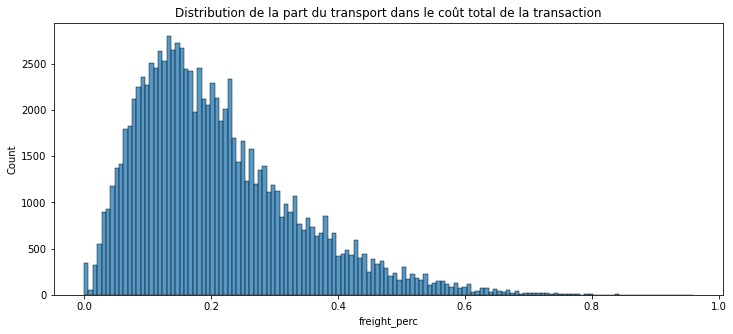

In [59]:
plt.figure(figsize=(12, 5))
sns.histplot(itm_pay['freight_perc'])
plt.title('Distribution de la part du transport dans le coût total de la transaction')
plt.show()

In [60]:
itm_pay['freight_perc'].describe()

count    98665.000000
mean         0.208960
std          0.125909
min          0.000000
25%          0.116559
50%          0.183356
75%          0.275676
max          0.959474
Name: freight_perc, dtype: float64

Corrélations linéraires de la table fusionnée Items_Payments
------------------------------------------------------------


<AxesSubplot:>

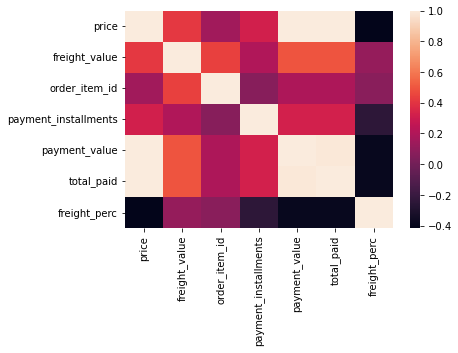

In [61]:
itm_pay_quanti = itm_pay.select_dtypes(include=np.number)
print('Corrélations linéraires de la table fusionnée Items_Payments')
print('------------------------------------------------------------')
sns.heatmap(itm_pay_quanti.corr())

In [62]:
itm_pay_rev = pd.merge(itm_pay, rev, how='inner', on='order_id')
print("Influence du pourcentage de frais de transport dans la satisfaction")
print("-------------------------------------------------------------------")
itm_pay_rev[['freight_perc', 'review_score']].corr()

Influence du pourcentage de frais de transport dans la satisfaction
-------------------------------------------------------------------


,freight_perc,review_score
freight_perc,1.000000,-0.021858
review_score,-0.021858,1.000000


<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Items</b><br>
    
**Outliers**
    
Bien que certains prix praissent suprenants (très bas, comme 0.85 BRL, ou au contraire très élevés, comme 6735 BRL), rien ne laisse supposer l'existance d'Outliers dans ce jeu de données. Mieux encore, nous avons pu lever le doute sur le supposé outlier de la commande à 13 664 BRL que nous avons identifié lors de l'étude de la table `Payments` : la commande est bien retrouvée ici et justifiée dans le détail par un ticket de 8 articles qui, avec ajout des frais de port, nous permet bien de tomber sur le total annoncé.
    
En étudiant la part du transport dans les transaction, on s'aperçoit que bien que la moyenne soit fixée à un chiffre entendable (20% du total de la transaction), certaines valeurs atteignent des niveaux critiques (jusqu'à 95% du total de la transaction). Cependant, en étudiant la distribution de cette nouvelle variable, il ne semble pas y avoir d'outlier.
    
Enfin, les tables `Items` et `Payments` ne donnent pas exactement les mêmes informations relatives au prix payé par le client : outre les différences de décimales négligeables, il manque la table `Items` 774 lignes de commandes par rapport à la table `Payments`, et pour 763 lignes que ces deux tables ont en commun, les montants ne sont pas identiques.<br><br>
    
**Corrélations linéraires**
    
Il semble exister des corrélations linéaires notables entre :
- Le prix payé par le client et le montant du transport
- Le nombre d'articles dans la commadne et le montant du transport
    
Ainsi que des corrélations négatives entre la part du transport dans le montant total de la transaction et :
- Le prix
- Le nombre de mensualités avec lequel la transaction a été réglée
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch3_7" style="color: orange;">3.7 Products</div>

In [63]:
pro.shape

(32951, 9)

In [64]:
pro.describe(include='all')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


In [65]:
pro.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


<AxesSubplot:>

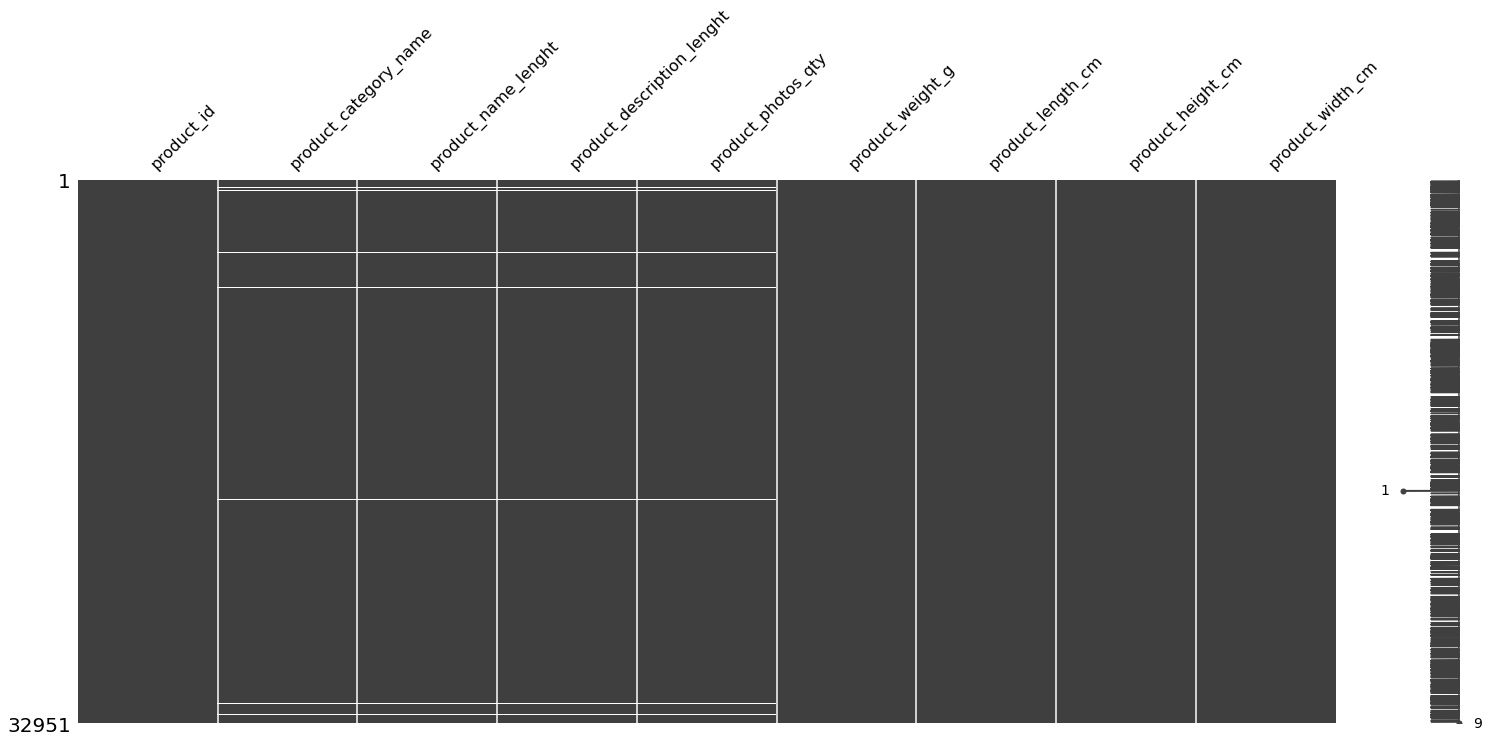

In [66]:
msno.matrix(pro)

In [67]:
(pro.isna().sum()/pro.shape[0]).sort_values(ascending=False)

product_category_name         0.018512
product_name_lenght           0.018512
product_description_lenght    0.018512
product_photos_qty            0.018512
product_weight_g              0.000061
product_length_cm             0.000061
product_height_cm             0.000061
product_width_cm              0.000061
product_id                    0.000000
dtype: float64

In [68]:
pro_quanti = pro.select_dtypes(include=np.number)

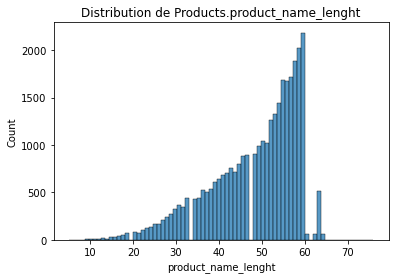

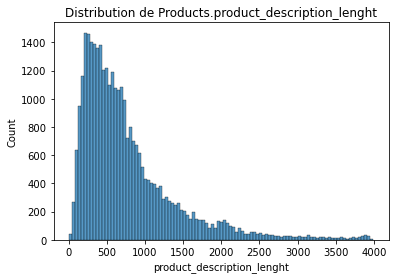

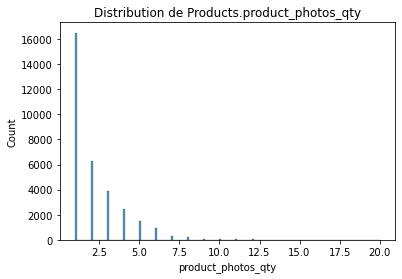

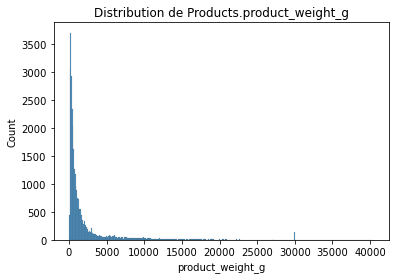

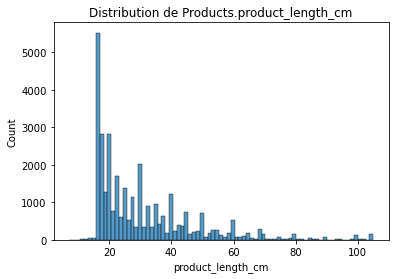

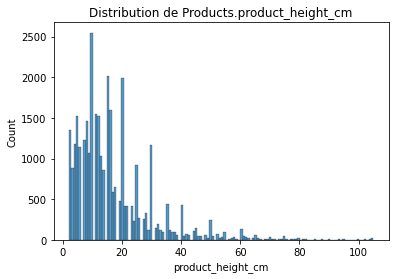

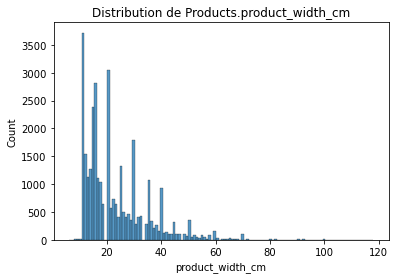

In [69]:
display_distri(pro_quanti, dataset_name='Products')

In [70]:
pro_agg = pro.groupby('product_category_name').count().reset_index()

In [71]:
pro_mean = pro.groupby('product_category_name').mean().reset_index()

Relation entre les variables quantitatives
------------------------------------------


<AxesSubplot:>

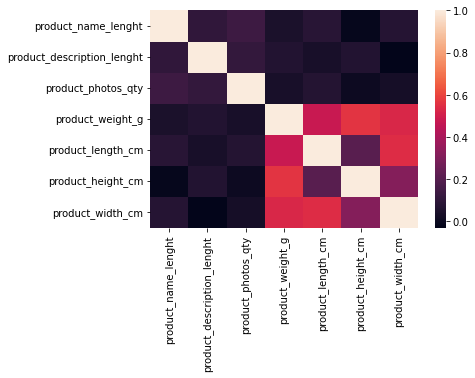

In [72]:
print("Relation entre les variables quantitatives")
print("------------------------------------------")
sns.heatmap(pro_quanti.corr())

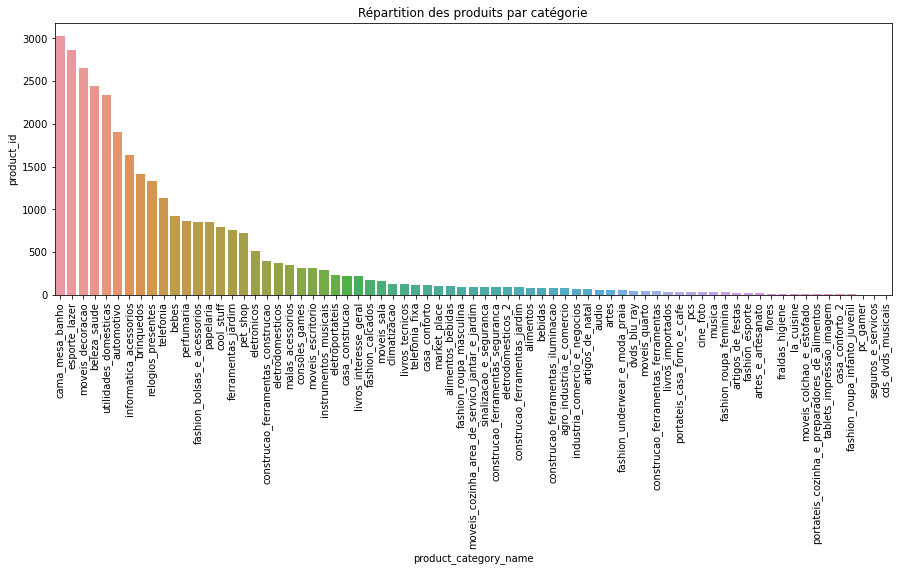

In [73]:
plt.figure(figsize=(15, 5))
sns.barplot(data=pro_agg.sort_values(by='product_id', ascending=False), x='product_category_name', y='product_id')
plt.xticks(rotation=90)
plt.title('Répartition des produits par catégorie')
plt.show()

In [74]:
print(f"Part des 10 premières catégories dans le nombre total d'articles : {pro_agg.sort_values(by='product_id', ascending=False).loc[:10, 'product_id'].sum(axis=0) / len(pro)}")

Part des 10 premières catégories dans le nombre total d'articles : 0.9541136839549634


In [75]:
pro['product_category_name'].fillna('unknown', inplace=True)

In [76]:
itm_pro = pd.merge(itm, pro, how='inner', on='product_id')
itm_pro.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0


In [77]:
itm_pro_price = itm_pro.groupby('product_category_name').sum().reset_index()
itm_pro_nb = itm_pro.groupby('product_category_name').count().reset_index()
itm_pro_agg = pd.DataFrame({'category': itm_pro_price['product_category_name'],
                            'nb_art': pro_agg['product_id'],
                            'nb_photo': pro_mean['product_photos_qty'],
                            'nb_bought': itm_pro_nb['product_id'],
                            'amount_spent': itm_pro_price['price']})

In [78]:
itm_pro_agg.sort_values(by='nb_bought', ascending=False).head(15)

,category,nb_art,nb_photo,nb_bought,amount_spent
13,cama_mesa_banho,3029.0,1.392539,11115,1036988.68
11,beleza_saude,2444.0,1.624386,9670,1258681.34
32,esporte_lazer,2867.0,2.135333,8641,988048.97
54,moveis_decoracao,2657.0,2.400828,8334,729762.49
44,informatica_acessorios,1639.0,1.987797,7827,911954.32
73,utilidades_domesticas,NaN,NaN,6964,632248.66
66,relogios_presentes,1329.0,2.234011,5991,1205005.68
70,telefonia,1134.0,2.759259,4545,323667.53
40,ferramentas_jardim,753.0,2.423639,4347,485256.46
8,automotivo,1900.0,2.636842,4235,592720.11


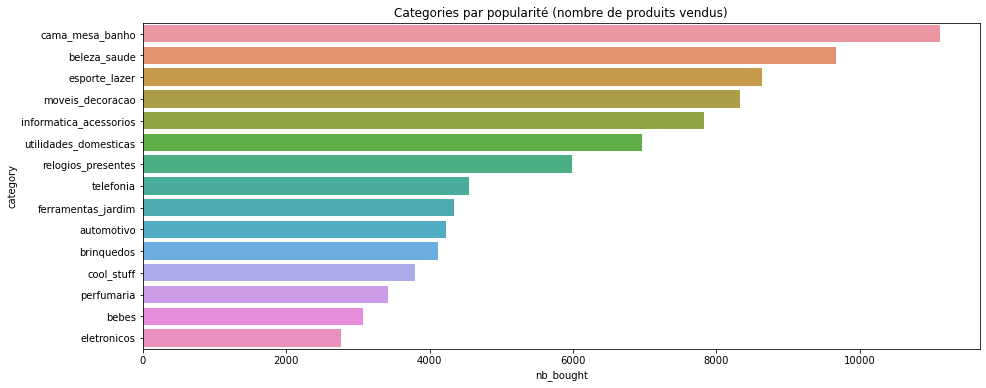

In [79]:
plt.figure(figsize=(15, 6))
sns.barplot(data=itm_pro_agg.sort_values(by='nb_bought', ascending=False).head(15), y='category', x='nb_bought')
plt.title('Categories par popularité (nombre de produits vendus)')
plt.show()

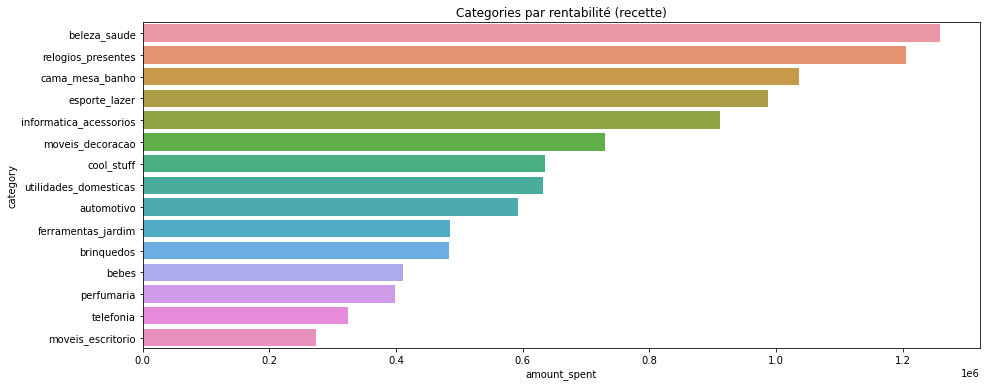

In [80]:
plt.figure(figsize=(15, 6))
sns.barplot(data=itm_pro_agg.sort_values(by='amount_spent', ascending=False).head(15), y='category', x='amount_spent')
plt.title('Categories par rentabilité (recette)')
plt.show()

Corrélation linéaire de l'aggrégation
-------------------------------------


<AxesSubplot:>

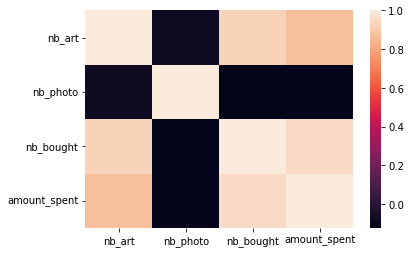

In [81]:
print("Corrélation linéaire de l'aggrégation")
print('-------------------------------------')
sns.heatmap(itm_pro_agg.corr())

Recette en fonction du nombre d'articles vendus
-----------------------------------------------


<Figure size 1080x432 with 0 Axes>

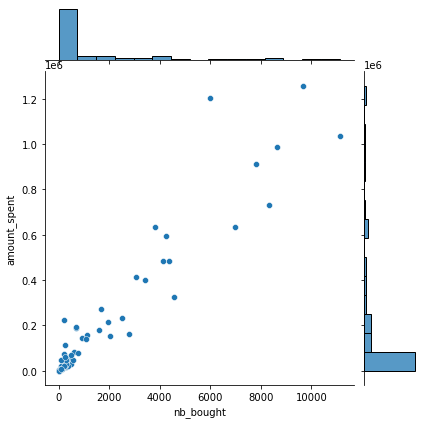

In [82]:
print("Recette en fonction du nombre d'articles vendus")
print('-----------------------------------------------')
plt.figure(figsize=(15, 6))
sns.jointplot(data=itm_pro_agg, y='amount_spent', x='nb_bought')
plt.show()

Nombre d'articles vendus en fonction du nombre disponible dans une catégorie
----------------------------------------------------------------------------


<Figure size 1080x432 with 0 Axes>

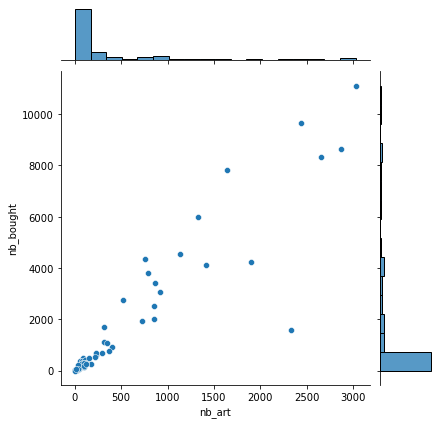

In [83]:
print("Nombre d'articles vendus en fonction du nombre disponible dans une catégorie")
print('----------------------------------------------------------------------------')
plt.figure(figsize=(15, 6))
sns.jointplot(data=itm_pro_agg, y='nb_bought', x='nb_art')
plt.show()

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Products</b><br>
    
La table `Products` n'est pas très informative. Elle nous permet néanmoins d'identifier les catégories de produits les plus représentées (nombre de produits proposés), les plus populaires (nombre de produits vendus) et les plus rentables (meilleure recette).
    
On peut d'ailleurs établir des corrélations linéraires très importantes (0.92 à 0.95) entre ces 3 variables, ce tend à nous donner un classement identique en regardant la répartition de chacune d'entre elles.
    
Le reste des données disponibles (dimensions et poids de l'article, nombre de photos) ne semble apporter aucun supplément d'information utile.
    
On constate que certaines valeurs manquantes nous laissent avec certains produits pour lesquels nous n'avons que leur identifiant.
    
</div>

[*(Retour sommaire)*](#ch0)

## <div id="ch3_8" style="color: orange;">3.8 Sellers</div>

In [84]:
sel.shape

(3095, 4)

In [85]:
sel.describe(include='all')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.000000,3095,3095
unique,3095,NaN,611,23
top,3442f8959a84dea7ee197c632cb2df15,NaN,sao paulo,SP
freq,1,NaN,694,1849
mean,NaN,32291.059451,NaN,NaN
std,NaN,32713.453830,NaN,NaN
min,NaN,1001.000000,NaN,NaN
25%,NaN,7093.500000,NaN,NaN
50%,NaN,14940.000000,NaN,NaN
75%,NaN,64552.500000,NaN,NaN


In [86]:
sel.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


<AxesSubplot:>

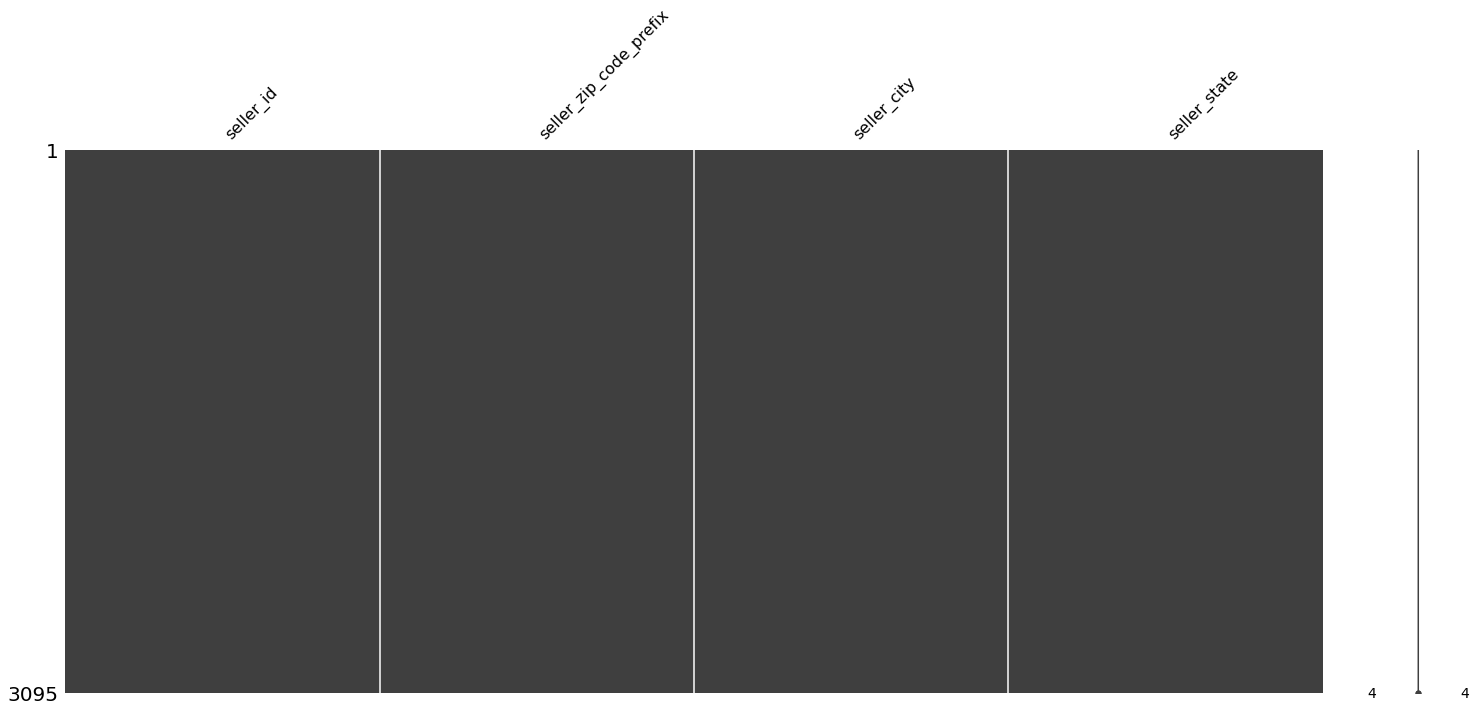

In [87]:
msno.matrix(sel)

In [88]:
(sel.isna().sum()/sel.shape[0]).sort_values(ascending=False)

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

In [89]:
geo_st = geo.drop_duplicates(subset='geolocation_state')
sel_geo = pd.merge(sel, geo_st, how='left', left_on='seller_state', right_on='geolocation_state')
sel_geo.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,1037,-23.545621,-46.639292,sao paulo,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,1037,-23.545621,-46.639292,sao paulo,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20010,-22.902472,-43.174059,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,1037,-23.545621,-46.639292,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,1037,-23.545621,-46.639292,sao paulo,SP


In [184]:
print("Localisation des vendeurs :")
print()
states = sel_geo['seller_state'].unique()
m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=(-19.5, -54.39), zoom=3)
for s in states:
    markers = [Marker(location=(r['geolocation_lat'], r['geolocation_lng'])) 
               for idx, r in sel_geo[(sel_geo['seller_state'] == s)].iterrows()]
    cluster = MarkerCluster(markers=tuple(markers))
    m.add_layer(cluster)
m

Localisation des vendeurs :



Map(center=[-19.5, -54.39], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

<img src="img/leaf_seller_loc.png">

In [90]:
itm_sel_geo = pd.merge(itm, sel_geo, how='left', on='seller_id')
isgo = pd.merge(itm_sel_geo, ods, how='left', on='order_id')
isgoc = pd.merge(isgo, cus, how='left', on='customer_id')
isgocr = pd.merge(isgoc, rev, how='left', on='order_id')
isgocr.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,nb_orders,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,volta redonda,SP,1037,-23.545621,-46.639292,sao paulo,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,1,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,3471,sao paulo,SP,1037,-23.545621,-46.639292,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,2,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,37564,borda da mata,MG,30001,-19.923989,-43.935706,belo horizonte,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,1,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,14403,franca,SP,1037,-23.545621,-46.639292,sao paulo,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,1,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,87900,loanda,PR,80010,-25.435488,-49.270214,curitiba,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,1,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02,2017-03-03 10:54:59


In [91]:
isgocr['purchase_timestamp'] = isgocr['order_purchase_timestamp'].apply(lambda x: f"{int(x.year)}{str(int(x.month)).rjust(2, '0')}")
isgocr.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,nb_orders,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,volta redonda,SP,1037,-23.545621,-46.639292,sao paulo,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,1,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,201709
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,3471,sao paulo,SP,1037,-23.545621,-46.639292,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,2,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13,2017-05-15 11:34:13,201704
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,37564,borda da mata,MG,30001,-19.923989,-43.935706,belo horizonte,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,1,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23,2018-01-23 16:06:31,201801
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,14403,franca,SP,1037,-23.545621,-46.639292,sao paulo,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,1,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15,2018-08-15 16:39:01,201808
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,87900,loanda,PR,80010,-25.435488,-49.270214,curitiba,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,1,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02,2017-03-03 10:54:59,201702


In [92]:
isgocr_agg = isgocr.groupby(['purchase_timestamp', 'review_score']).count().loc[:, 'order_id'].reset_index()
isgocr_agg.head(10)

,purchase_timestamp,review_score,order_id
0,201609,1.0,6
1,201610,1.0,89
2,201610,2.0,12
3,201610,3.0,27
4,201610,4.0,55
5,201610,5.0,178
6,201612,5.0,1
7,201701,1.0,114
8,201701,2.0,35
9,201701,3.0,80


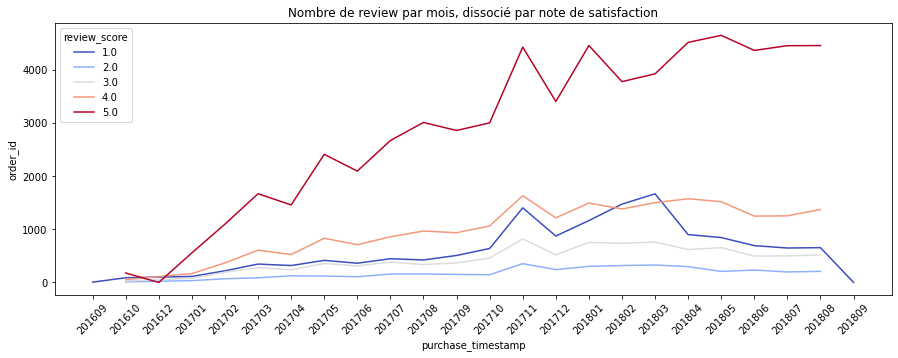

In [93]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=isgocr_agg, x='purchase_timestamp', y='order_id', hue='review_score', palette='coolwarm')
plt.title('Nombre de review par mois, dissocié par note de satisfaction')
plt.xticks(rotation=45)
plt.show()

In [94]:
isgocr_mean = isgocr.groupby('purchase_timestamp').mean().loc[:, 'review_score'].reset_index()
isgocr_mean.head(10)

,purchase_timestamp,review_score
0,201609,1.000000
1,201610,3.612188
2,201612,5.000000
3,201701,4.069110
4,201702,4.054331
5,201703,4.059118
6,201704,4.004494
7,201705,4.136649
8,201706,4.133593
9,201707,4.139196


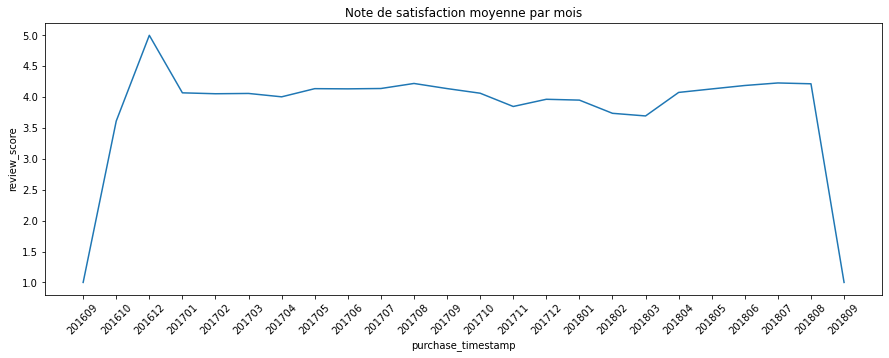

In [95]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=isgocr_mean, x='purchase_timestamp', y='review_score')
plt.title('Note de satisfaction moyenne par mois')
plt.xticks(rotation=45)
plt.show()

In [96]:
isgocr['distance'] = isgocr.apply(lambda x: calc_distance(x['seller_state'], x['customer_state']), axis=1)

In [97]:
isgocr_arrived = isgocr.dropna(subset=['order_purchase_timestamp', 'order_delivered_customer_date'])
isgocr_arrived['dispatch_offset'] = isgocr_arrived['order_delivered_customer_date'] - isgocr_arrived['order_purchase_timestamp']
isgocr_arrived['dispatch_days'] = isgocr_arrived['dispatch_offset'].dt.days

C:\Users\aledo\AppData\Local\Temp\ipykernel_5148\2316154748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isgocr_arrived['dispatch_offset'] = isgocr_arrived['order_delivered_customer_date'] - isgocr_arrived['order_purchase_timestamp']
C:\Users\aledo\AppData\Local\Temp\ipykernel_5148\2316154748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isgocr_arrived['dispatch_days'] = isgocr_arrived['dispatch_offset'].dt.days


In [98]:
isgocr_arrived['dispatch_days'] = isgocr_arrived['dispatch_days'].astype('int')

C:\Users\aledo\AppData\Local\Temp\ipykernel_5148\2894509356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isgocr_arrived['dispatch_days'] = isgocr_arrived['dispatch_days'].astype('int')


In [99]:
isgocr_arrived.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,nb_orders,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,purchase_timestamp,distance,dispatch_offset,dispatch_days
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,volta redonda,SP,1037,-23.545621,-46.639292,sao paulo,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,1,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,201709,361.745680,7 days 14:44:46,7
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,3471,sao paulo,SP,1037,-23.545621,-46.639292,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,2,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13,2017-05-15 11:34:13,201704,0.000000,16 days 05:11:18,16
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,37564,borda da mata,MG,30001,-19.923989,-43.935706,belo horizonte,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,1,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23,2018-01-23 16:06:31,201801,0.000000,7 days 22:45:45,7
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,14403,franca,SP,1037,-23.545621,-46.639292,sao paulo,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,1,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15,2018-08-15 16:39:01,201808,0.000000,6 days 03:32:04,6
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,87900,loanda,PR,80010,-25.435488,-49.270214,curitiba,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,1,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02,2017-03-03 10:54:59,201702,339.003763,25 days 02:44:40,25


Corrélations linéraires des tables fusionnées
---------------------------------------------


<AxesSubplot:>

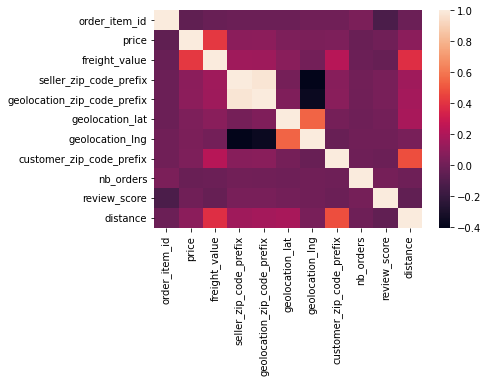

In [100]:
print('Corrélations linéraires des tables fusionnées')
print('---------------------------------------------')
sns.heatmap(isgocr.corr())

<AxesSubplot:xlabel='dispatch_days', ylabel='distance'>

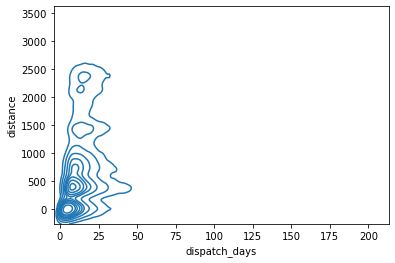

In [101]:
sns.kdeplot(data=isgocr_arrived, x='dispatch_days', y='distance')

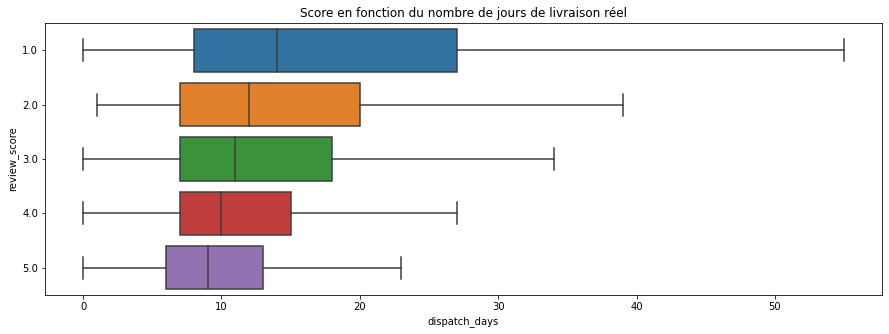

In [102]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=isgocr_arrived, x='dispatch_days', y='review_score', orient='h', showfliers=False)
plt.title('Score en fonction du nombre de jours de livraison réel')
plt.show()

<div class="alert alert-block alert-info">
    <b><u>Analyse</u> : Sellers</b><br>
    
**Localisation des vendeurs**
    
En complément que ce nous avions déjà observé sur la table [Reviews](#ch3_4), on constate ici que la répartition des vendeurs sur le territoire brésilien est concentrée au Sud-Ouest, et qu'il n'est donc pas suprenant que les délais de transport, tous articles confondus, mettent plus de temps à atteindre les clients localisés au Nord, c'est-à-dire ceux qui ont globalement attribué des notes de satisfaction inférieures à la moyenne et pour lesquels les principaux irritants remontés concernaient la livraison.
    
**Dernières analyses toutes tables aggrégées**
    
L'association de l'ensemble des tables nous permet de dégager quelques remarques supplémentaires :
- Malgré une apparente stabilité de la note moyenne de satisfaction de mois en mois, on constate que la tendance par note est différente : les bonnes notes (4 et 5) connaissent une hausse constante, alors que la note la plus basse (1) est à la baisse sur les 6 derniers mois.
- Il y a une corrélation (logique, heureusement) entre la distance qui relie un fournisseur et un client d'une part, et le prix du transport et celui de la transaction d'autre part.
- L'approche en distribution par noyau nous montre une relation de corrélation (non linéaire) entre la distance client-fournisseur et le nombre de jour que met la commande à parvenir à destination.
- enfin, l'approche par quartiles nous permet de supposer l'existence d'une influence de la distance client-fournisseur sur l'attribution des notes de satisfaction par les clients.

    
</div>

[*(Retour sommaire)*](#ch0)

# <div id="ch4" style="color: blue">4. Feature engineering</div>

L'analyse réalisée dans le présent notebook nous a permis de dégager plusieurs variables d'influence que nous allons à présent pouvoir utiliser.

Nous allons créer 2 dataset :
- Un premier comportant les variables calculées de Récence (date de dernière commande), Fréquence (des commandes sur une période) et Montant (de la dernière commande + sur une période) ==> ce sont des métriques souvent utilisées en marketing
- Un second constitué des variables d'intérêt des tables aggrégées du jeu de données d'origine, augmenté des variables d'influence que nous avons identifiées durant la phase d'analyse

Les performance de ces deux jeux de données seront ensuite comparées dans une optique de segmentation des clients.

## <div id="ch4_1" style="color: orange;">4.1 RFM</div>

### Récence

Nous allons exprimer la récence en termes de nombre de jours avant la date la plus récente disponible dans le dataset `Orders`

In [103]:
max_date = ods['order_purchase_timestamp'].max()
print(f"Date d'achat la plus récente dans `Orders` : {max_date}")
print("------------------------------------------")

Date d'achat la plus récente dans `Orders` : 2018-10-17 17:30:18
------------------------------------------


In [104]:
ods['purchase_recence'] = ods['order_purchase_timestamp'] - max_date
ods['purchase_recence'] = ods['purchase_recence'].dt.days

### Fréquence

In [105]:
min_date = ods['order_purchase_timestamp'].min()
print(f"Date d'achat la plus ancienne dans `Orders` : {min_date}")
print("-------------------------------------------")
print()
nb_months = int(np.floor((max_date - min_date).days / 30)) + 1
print(f"Nombre de mois entre les dates min et max : {nb_months}")
print("-----------------------------------------")

Date d'achat la plus ancienne dans `Orders` : 2016-09-04 21:15:19
-------------------------------------------

Nombre de mois entre les dates min et max : 26
-----------------------------------------


In [106]:
cus['purchase_frequency'] = cus['nb_orders'] / nb_months

### Montant

Le montant sera exprimé de 3 manières :
- Montant de la dernière commande passée
- Montant total dépensé chez Olist
- Panier moyen sur l'ensemble des transactions réalisée chez Olist

In [107]:
pay_sum = pay.groupby('order_id').sum().reset_index()

In [108]:
ods_pay = pd.merge(ods, pay_sum, how='left', on='order_id')

In [109]:
ods_pay['payment_value'] = ods_pay['payment_value'].fillna(0)

In [110]:
ods_pay = pd.merge(ods_pay[['order_id', 'customer_id', 'purchase_recence']], ods_pay[['order_id', 'payment_value']],
                  how='left', on='order_id')

In [111]:
cus_rfm = pd.merge(cus, ods_pay, how='left', on='customer_id')

In [112]:
cus_rfm_sum = cus_rfm[['customer_unique_id', 'payment_value']].groupby('customer_unique_id').sum().reset_index()
cus_rfm_mean = cus_rfm[['customer_unique_id', 'payment_value']].groupby('customer_unique_id').max().reset_index()

In [113]:
cus_rfm_sum.rename(columns={'payment_value': 'payment_total'}, inplace=True)
cus_rfm_mean.rename(columns={'payment_value': 'payment_mean'}, inplace=True)

In [114]:
cus_rfm_sorted = cus_rfm.sort_values(by='purchase_recence', ascending=False)

In [115]:
cus_rfm_sorted.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,nb_orders,purchase_frequency,order_id,purchase_recence,payment_value
85415,a4b417188addbc05b26b72d5e44837a1,87ab9fec999db8bd5774917de3cdf01c,18077,sorocaba,SP,1,0.038462,10a045cdf6a5650c21e9cfeb60384c16,0,89.71
69139,856336203359aa6a61bf3826f7d84c49,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,2,0.076923,b059ee4de278302d550a3035c4cdb740,-1,222.03
68312,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,registro,SP,3,0.115385,a2ac6dad85cf8af5b0afb510a240fe8c,-14,197.55
75902,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,2,0.076923,616fa7d4871b87832197b2a137a115d2,-17,80.38
75985,2823ffda607a2316375088e0d00005ec,9bb92bebd4cb7511e1a02d5e50bc4655,7176,guarulhos,SP,1,0.038462,392ed9afd714e3c74767d0c4d3e3f477,-19,137.03


In [116]:
cus_rfm_unq = cus_rfm_sorted.drop_duplicates(
    subset='customer_unique_id', keep='first').loc[:, ['customer_unique_id', 'purchase_frequency', 'payment_value',
                                                      'purchase_recence', 'nb_orders']]

In [117]:
cus_rfm_unq.rename(columns={'payment_value': 'payment_last'}, inplace=True)

In [118]:
cus_rfm = pd.merge(cus_rfm_unq, cus_rfm_sum, how='left', on='customer_unique_id')
cus_rfm = pd.merge(cus_rfm, cus_rfm_mean, how='left', on='customer_unique_id')

In [119]:
cus_rfm.to_csv('data/rfm.csv', index=False)

In [120]:
cus_rfm.shape

(96096, 7)

In [121]:
cus_rfm.head()

,customer_unique_id,purchase_frequency,payment_last,purchase_recence,nb_orders,payment_total,payment_mean
0,87ab9fec999db8bd5774917de3cdf01c,0.038462,89.71,0,1,89.71,89.71
1,262e1f1e26e92e86375f86840b4ffd63,0.076923,222.03,-1,2,444.06,222.03
2,af5454198a97379394cacf676e1e96cb,0.115385,197.55,-14,3,592.65,197.55
3,634420a0ea42302205032ed44ac7fccc,0.076923,80.38,-17,2,160.76,80.38
4,9bb92bebd4cb7511e1a02d5e50bc4655,0.038462,137.03,-19,1,137.03,137.03


In [122]:
cus_rfm.describe(include='all')

,customer_unique_id,purchase_frequency,payment_last,purchase_recence,nb_orders,payment_total,payment_mean
count,96096,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
unique,96096,NaN,NaN,NaN,NaN,NaN,NaN
top,87ab9fec999db8bd5774917de3cdf01c,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.039800,161.340983,-288.735660,1.034809,166.592492,162.922440
std,NaN,0.008246,222.888523,153.414678,0.214384,231.428332,224.017282
min,NaN,0.038462,0.000000,-773.000000,1.000000,0.000000,0.000000
25%,NaN,0.038462,62.077500,-398.000000,1.000000,63.120000,62.700000
50%,NaN,0.038462,105.380000,-269.000000,1.000000,108.000000,106.690000
75%,NaN,0.038462,177.042500,-164.000000,1.000000,183.530000,178.782500


Nous obtenons donc un dataset dans lequel les information RFM sont représentées par les variables suivantes :
- **Récence** : `purchase_recence`
- **Fréquence** : `purchase_frequency`, `nb_orders`
- **Montant** : `payment_last`, `payment_mean`, `payment_total`

[*(Retour sommaire)*](#ch0)

## <div id="ch4_2" style="color: orange;">4.2 Aggrégations et nouvelles variables</div>

### Calcul des positions moyennes de chaque Etat et ville issus de `Geolocation`

Nous nous en servirons afin de remplir les valeurs manquantes de Zip-code lors de la correspondance entre les tables `Customers` et `Sellers` avec la table `Geolocation`

In [123]:
states = geo['geolocation_state'].unique()
st_name = []
st_lat = []
st_lng = []
for s in states:
    st_name.append(s)
    st_lat.append(geo.loc[geo['geolocation_state'] == s, 'geolocation_lat'].mean())
    st_lng.append(geo.loc[geo['geolocation_state'] == s, 'geolocation_lng'].mean())

In [124]:
sts = pd.DataFrame(np.array([st_name, st_lat, st_lng]).T, columns=['state_name', 'state_lat', 'state_lng'])

In [125]:
sts.head()

,state_name,state_lat,state_lng
0,SP,-23.155308346172944,-47.08407367161309
1,RN,-5.856702064225209,-35.99007862513833
2,AC,-9.702555041197337,-68.45185194823809
3,RJ,-22.74347732166962,-43.15554026830261
4,ES,-20.105145324187276,-40.50318322322486


In [129]:
cities = geo['geolocation_city'].unique()
ct_name = []
ct_lat = []
ct_lng = []
for c in cities:
    ct_name.append(c)
    ct_lat.append(geo.loc[geo['geolocation_city'] == c, 'geolocation_lat'].mean())
    ct_lng.append(geo.loc[geo['geolocation_city'] == c, 'geolocation_lng'].mean())
    print(c)

sao paulo
são paulo
sao bernardo do campo
jundiaí
taboão da serra
sãopaulo
sp
sa£o paulo
sao jose dos campos
osasco
carapicuíba
carapicuiba
barueri
santana de parnaiba
pirapora do bom jesus
santana de parnaíba
jandira
itapevi
cotia
taboao da serra
vargem grande paulista
embu das artes
itapecerica da serra
embu
são lourenço da serra
sao lourenco da serra
embu-guacu
embu-guaçu
embu guaçu
juquitiba
embu guacu
embuguacu
guarulhos
adamantina
guarulhos-sp
aruja
arujá
santa isabel
mairipora
mairiporã
cajamar
caieiras
jordanesia
polvilho
mauá
jordanésia
franco da rocha
francisco morato
poa
itaquaquecetuba
ferraz de vasconcelos
poá
suzano
mogi das cruzes
mogidascruzes
salesopolis
biritiba-mirim
guararema
salesópolis
biritiba mirim
santo andre
santo andré
maua
ribeirão pires
ribeirao pires
rio grande da serra
sao caetano do sul
são caetano do sul
são bernardo do campo
sbcampo
diadema
santos
bertioga
caruara
sao vicente
são vicente
guarujá
guaruja
cubatao
cubatão
sao sebastiao
ubatuba
ilhabela
ca

avanhandava
alto alegre
luiziânia
barbosa
lins
guaicara
sabino
getulina
guaimbe
guaiçara
guaimbê
cafelandia
cafelândia
guaranta
guarantã
simoes
presidente alves
pongai
avai
pirajui
uru
pongaí
pirajuí
balbinos
avaí
guararapes
rubiacea
bento de abreu
rubiácea
mirandopolis
valparaiso
lavinia
mirandópolis
lavínia
valparaíso
tres aliancas
andradina
castilho
guaracai
guaraçaí
murutinga do sul
nova independencia
nova independência
bauru
arealva
agudos
iacanga
reginopolis
paulistania
reginópolis
domelia
paulistânia
jacuba
jau
pederneiras
jaú
itapui
bariri
itaju
boraceia
macatuba
bocaina
itapuí
boracéia
santelmo
potunduva
guaianas
barra bonita
brotas
igaracu do tiete
dois corregos
mineiros do tiete
torrinha
mineiros do tietê
dois córregos
igaraçu do tietê
santa maria da serra
guarapua
lupércio
garca
duartina
galia
álvaro de carvalho
piratininga
garça
cabralia paulista
ubirajara
lupercio
alvinlandia
lucianópolis
fernao
alvinlândia
lucianopolis
gália
cabrália paulista
alvaro de carvalho
jafa
fern

pacotuba
burarama
venda nova do imigrante-es
corrego dos monos
sao jose do calcado
mimoso do sul
muqui
atilio vivacqua
apiaca
bom jesus do norte
são josé do calçado
apiacá
sao jose das torres
alto calcado
cafe
alegre
jerônimo monteiro
divino de sao lourenco
dores do rio preto
guacui
ibitirama
jeronimo monteiro
celina
guaçuí
rive
são pedro de rates
divino de são lourenço
afonso claudio
santa maria de jetiba
santa teresa
sao roque do canaa
laranja da terra
itarana
santa leopoldina
sao roque do cannaa
joao neiva
santa maria de jetibá
afonso cláudio
joão neiva
ibiracu
são roque do canaã
itaguacu
brejetuba
itaguaçu
itaimbe
ibiraçu
santo antonio do canaa
sao joao de petropolis
santo antônio do canaã
acioli
colatina
são gabriel da palha
baixo guandu
pancas
vila valerio
mantenopolis
sao gabriel da palha
marilandia
vila verde
alto rio novo
governador lindenberg
mantenópolis
sao domingos do norte
aguia branca
marilândia
lajinha
novo brasil
são domingos do norte
quilometro 14 do mutum
vila valéri

sao joao da serra
pinheiro grosso
costas da mantiqueira
abreus
oliveira fortes
vitorinos
dores do paraibuna
vitorinos - alto rio doce
são sebastião dos torres
sao joao del rei
lagoa dourada
tiradentes
resende costa
sao tiago
são joão del rei
conceicao da barra de minas
coronel xavier chaves
santa cruz de minas
itutinga
nazareno
são sebastião da vitória
prados
ritapolis
são tiago
merces de agua limpa
conceição da barra de minas
rio das mortes
sao sebastiao da vitoria
mercês de água limpa
ritápolis
conselheiro lafaiete
ouro branco
congonhas
casa grande
lamim
piranga
senhora de oliveira
rio espera
cristiano otoni
santana dos montes
queluzito
itaverava
caranaiba
alto maranhao
catas altas da noruega
caranaíba
pinheiros altos
santo antonio do pirapetinga
rio melo
vicosa
visconde do rio branco
cajuri
uba
ervalia
coimbra
ubá
sao geraldo
são miguel do anta
porto firme
tocantins
guidoval
sao miguel do anta
divinésia
teixeiras
viçosa
divinesia
ervália
senador firmino
são geraldo
rodeiro
guiricema

rio vermelho
milho verde
gouveia
alvorada de minas
senador mourao
felício dos santos
senador modestino gonçalves
gouvea
serra azul de minas
couto de magalhaes de minas
felicio dos santos
santo antonio do itambe
presidente kubitschek
sao joao da chapada
sao goncalo do rio das pedras
desembargador otoni
santo antônio do itambé
couto de magalhães de minas
pedra menina
varzea da palma
pirapora
lassance
tres marias
corinto
buritizeiro
três marias
santo hipolito
buenópolis
buenopolis
sao romao
várzea da palma
augusto de lima
joaquim felicio
santa fe de minas
monjolos
guaicui
são romão
andrequice
joaquim felício
presidente juscelino
santo hipólito
santa fé de minas
sao joao do pacui
jequitai
brasilia de minas
campo azul
olhos-d agua
japonvar
brasília de minas
bocaiuva
ponto chique
icaraí de minas
icarai de minas
bocaiúva
alvacao
ibiai
francisco dumont
olhos d'agua
patis
ibiaí
ubai
lagoa dos patos
sao joao da lagoa
coracao de jesus
claro dos pocoes
luislândia
mirabela
engenheiro navarro
guarac

pau brasil
itagimirim
santa cruz cabrália
arraial d ajuda
eunápolis
mascote
guaratinga
itapebi
jucuruçu
teixeira de freitas
medeiros neto
itanhém
caravelas
nova viçosa
prado
cumuruxatiba
itanhem
itabatan
ibirapua
posto da mata
itabata
alcobaca
ibirajá
ibirapuã
nova vicosa
alcobaça
ibiraja
batinga
lajedao
itabatan (mucuri)
vereda
rio de contas
brumado
malhada de pedras
livramento de nossa senhora
paramirim
erico cardoso
aracatu
dom basílio
dom basilio
érico cardoso
itaquarai
piripa
maetinga
condeuba
presidente janio quadros
rio do antonio
rio do antônio
mortugaba
condeúba
cordeiros
piripá
guajeru
pindai
jacaraci
cacule
candiba
urandi
ibiassuce
ibiassucê
licinio de almeida
pindaí
caculé
licínio de almeida
tauape
irundiara
guanambi
carinhanha
iuiu
malhada
igapora
caetité
matina
feira da mata
palmas de monte alto
riacho de santana
caetite
lagoa real
sebastiao laranjeiras
sebastião laranjeiras
maniacu
igaporã
macaubas
tanque novo
botupora
ibipitanga
caturama
boquira
rio do pires
macaúbas
ib

vila sao francisco
olho dágua grande
sao bras
olho d'agua grande
são brás
pau d'arco
delmiro gouveia
pão de açúcar
batalha
olho d'agua das flores
piranhas
pao de acucar
olho d agua das flores
sao jose da tapera
agua branca
jaramataia
olho d'água das flores
monteiropolis
pariconha
jacare dos homens
são josé da tapera
olho d'água do casado
santana do ipanema
poco das trincheiras
dois riachos
inhapi
mata grande
maravilha
major isidoro
cacimbinhas
poço das trincheiras
canapi
olivenca
carneiros
senador rui palmeira
igaci
estrela de alagoas
palmeira dos indios
boca da mata
maribondo
belem
tanque d'arca
palmeira dos índios
atalaia
anadia
taquarana
cha preta
cajueiro
chã preta
paulo jacinto
quebrangulo
pindoba
mar vermelho
branquinha
santana do mundau
uniao dos palmares
sao jose da laje
união dos palmares
ibateguara
murici
são josé da laje
santana do mundaú
maragogi
sao luis do quitunde
joaquim gomes
japaratinga
novo lino
sao miguel dos milagres
matriz de camaragibe
porto calvo
paripueira
colo

lavras da mangabeira
barro
baixio
umari
ico
jaguaribe
jaguaribara
pereiro
icó
erere
feiticeiro
jaguaretama
varzea alegre
iguatu
antonina do norte
acopiara
quixelô
oros
catarina
carius
saboeiro
várzea alegre
aiuaba
jucas
quixelo
jucás
cariús
orós
guassussê
guassusse
taua
senador pompeu
arneiroz
parambu
piquet carneiro
solonopole
milha
deputado irapuan pinheiro
quiterianopolis
mombaça
mombaca
milhã
solonópole
tauá
mineirolândia
quiterianópolis
ibicua
crateus
novo oriente
crateús
monsenhor tabosa
sucesso
tamboril
boa viagem
quixeramobim
madalena
ibaretama
banabuiu
banabuiú
quixadá
juatama
teresina
luzilandia
jose de freitas
barras
esperantina
uniao
boa hora
união
porto
matias olimpio
joca marques
josé de freitas
lagoa alegre
joaquim pires
miguel alves
luzilândia
murici dos portelas
cabeceiras do piaui
morro do chapeu do piaui
nossa senhora dos remedios
madeiro
matias olímpio
luis correia
altos
parnaiba
piripiri
parnaíba
sigefredo pacheco
piracuruca
capitao de campos
cocal
cocal dos alves


sao raimundo das mangabeiras
pastos bons
alto parnaiba
loreto
sucupira do norte
são raimundo das mangabeiras
mirador
tasso fragoso
sao domingos do azeitao
fortaleza dos nogueiras
nova iorque
alto parnaíba
nova colinas
são félix de balsas
benedito leite
sao felix de balsas
imperatriz
acailandia
estreito
barra do corda
jenipapo dos vieiras
grajau
itaipava do grajau
carolina
itinga do maranhao
feira nova do maranhao
cidelandia
porto franco
joao lisboa
riachao
amarante do maranhao
campestre do maranhão
itinga do maranhão
sao francisco do brejao
campestre do maranhao
arame
sao pedro da agua branca
buritirana
vila nova dos martirios
vila nova dos martírios
são pedro da água branca
feira nova do maranhão
lajeado novo
senador la rocque
grajaú
açailândia
ribamar fiquene
montes altos
formosa da serra negra
davinopolis
governador edison lobao
riachão
são francisco do brejão
governador edison lobão
sao pedro dos crentes
senador la roque
ananindeua
marituba
santarem
santarém
itaituba
juruti
jacarea

indiara
palminopolis
jandaia
edealina
montividiu
parauna
turvelandia
ouroana
santo antonio da barra
edéia
paraúna
sao joao da parauna
acreúna
palminópolis
maurilândia
turvelândia
castelândia
riverlandia
santo antônio da barra
palmeiras de goias
sao luis de montes belos
adelandia
buriti de goias
são luís de montes belos
sanclerlandia
anicuns
aurilandia
turvania
sanclerlândia
mossamedes
mossâmedes
moipora
cachoeira de goias
cezarina
palmeiras de goiás
americano do brasil
firminopolis
amorinopolis
nazario
cachoeira de goiás
firminópolis
ivolândia
ivolandia
nazário
buriti de goiás
amorinópolis
arenopolis
ipora
baliza
bom jardim de goias
aragarcas
montes claros de goias
israelandia
itapirapuã
itapirapua
iporá
diorama
aragarças
britania
montes claros de goiás
jaupaci
santa fe de goias
santa fé de goiás
bom jardim de goiás
britânia
jacilandia
rubiataba
goianesia
ceres
morro agudo de goias
itapaci
jaragua
jaraguá
rialma
goianésia
carmo do rio verde
uruana
sao luiz do norte
rianapolis
hidrolina

primavera do leste
vera
campo verde
feliz natal
gaucha do norte
jaciara
sorriso
poxoreu
juscimeira
paranatinga
dom aquino
gaúcha do norte
poxoréu
nova ubiratã
nova brasilandia
planalto da serra
sao pedro da cipa
nova ubirata
santa elvira
ribas do rio pardo
maracaju
sidrolandia
rio brilhante
terenos
nova alvorada do sul
sidrolândia
prudencio thomaz
prudêncio thomaz
anhandui
anastacio
aquidauana
nioaque
porto murtinho
dois irmãos do buriti
bela vista
guia lopes da laguna
dois irmaos do buriti
anastácio
cipolandia
corumba
ladario
ladário
corumbá
miranda
bodoquena
sonora
sao gabriel do oeste
coxim
camapuã
são gabriel do oeste
pedro gomes
rio verde de mato grosso
rio negro
corguinho
rochedo
camapua
pontinha do cocho
figueirao
jaraguari
figueirão
aparecida do taboado
cassilandia
costa rica
alcinópolis
inocencia
chapadao do sul
paraíso das águas
paranaiba
paraiso das aguas
chapadão do sul
paranaíba
alcinopolis
selviria
cassilândia
inocência
agua clara
brasilandia
tres lagoas
santa rita do par

terra boa
engenheiro beltrão
japurá
sao manoel do parana
vidigal
campo mourao
janiopolis
moreira sales
roncador
goioere
mambore
juranda
campina da lagoa
nova cantu
campo mourão
mamborê
rancho alegre d'oeste
quarto centenario
goioerê
farol
rancho alegre d  oeste
4o. centenario
quarto centenário
janiópolis
4º centenario
paraná d'oeste
tapejara
mariluz
tuneiras do oeste
cruzeiro do oeste
maria helena
sao silvestre
altonia
umuarama
iporã
perola
guaipora
pérola
sao jorge do patrocinio
xambre
brasilândia do sul
ivate
icaraima
alto piquiri
perobal
cafezal do sul
francisco alves
serra dos dourados
brasilandia do sul
esperanca nova
icaraíma
ivaté
altônia
santa eliza
xambrê
são jorge do patrocínio
uniflor
paranacity
nova esperança
paranapoema
jardim olinda
alto parana
paranavai
paranavaí
são carlos do ivaí
paraiso do norte
são joão do caiuá
sao joao do caiua
tamboara
sao carlos do ivai
paraíso do norte
alto paraná
santo antonio do caiua
nova alianca do ivai
graciosa
santo antônio do caiuá
nova a

general camara
general câmara
westfalia
fazenda vilanova
mato leitão
westfália
vale verde
mato leitao
paverama
tabai
nova alvorada
muçum
encantado
progresso
arvorezinha
arroio do meio
boqueirao do leao
santa clara do sul
nova brescia
boqueirão do leão
anta gorda
capitao
ilopolis
doutor ricardo
relvado
serio
putinga
mucum
sério
ilópolis
nova bréscia
pouso novo
capitão
marques de souza
canudos do vale
itapuca
coqueiro baixo
forquetinha
vespasiano correa
itapucá
travesseiro
pelotas
sao lourenco do sul
camaqua
dom feliciano
capao do leao
são lourenço do sul
arambaré
chuvisca
cristal
camaquã
morro redondo
capão do leão
arambare
arroio do padre
colônia z-3
turuçu
colonia z-3
turucu
santa vitoria do palmar
monte bonito
são josé do norte
rio grande
santa vitória do palmar
mostardas
chui
sao jose do norte
chuí
quinta
jaguarao
arroio grande
pedro osorio
cerrito
jaguarão
herval
pedro osório
bage
pinheiro machado
dom pedrito
candiota
bagé
hulha negra
piratini
acegua
pedras altas
aceguá
colonia nov

In [130]:
cts = pd.DataFrame(np.array([ct_name, ct_lat, ct_lng]).T, columns=['city_name', 'city_lat', 'city_lng'])

In [131]:
cts.head()

,city_name,city_lat,city_lng
0,sao paulo,-23.570860225908756,-46.63324177930123
1,são paulo,-23.57338780921007,-46.63755622794558
2,sao bernardo do campo,-23.707626338404054,-46.56386871942162
3,jundiaí,-23.184937697139652,-46.90097422674049
4,taboão da serra,-23.62008702925047,-46.7798507855267


### `Items`, `Products` et `Sellers`

Les trois tables sont fusionnées

In [132]:
itm_pro = pd.merge(itm, pro[['product_id', 'product_category_name']], how='left', on='product_id')
itm_pro = itm_pro.drop('product_id', axis=1)

In [133]:
itm_pro_sel = pd.merge(itm_pro, sel[['seller_id', 'seller_city', 'seller_state']], how='left', on='seller_id')
itm_pro_sel = itm_pro_sel.drop('seller_id', axis=1)

In [134]:
itm_pro_sel.head()

,order_id,order_item_id,shipping_limit_date,price,freight_value,product_category_name,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,2017-09-19 09:45:35,58.90,13.29,cool_stuff,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,2017-05-03 11:05:13,239.90,19.93,pet_shop,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,2018-08-15 10:10:18,12.99,12.79,perfumaria,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,loanda,PR


Nous créons de nouvelles métriques permettant le regroupement par `order_id` tout en conservant les informations voulues sur les variables d'intérêt

In [135]:
itm_pro_sel = pd.merge(itm_pro_sel, cts, how='left', left_on='seller_city', right_on='city_name')

In [136]:
itm_pro_sel.rename(columns={'city_lat': 'seller_lat', 'city_lng': 'seller_lng'}, inplace=True)

In [137]:
for idx, row in itm_pro_sel[itm_pro_sel['city_name'].isna()].iterrows():
    itm_pro_sel.loc[itm_pro_sel['order_id'] == row['order_id'], 'seller_lat'] = float(
        sts.loc[sts['state_name'] == row['seller_state'], 'state_lat'])
    itm_pro_sel.loc[itm_pro_sel['order_id'] == row['order_id'], 'seller_lng'] = float(
        sts.loc[sts['state_name'] == row['seller_state'], 'state_lng'])

In [138]:
itm_pro_sel = itm_pro_sel.drop(['seller_city', 'seller_state'], axis=1)

In [139]:
itm_pro_sel[['seller_lat', 'seller_lng']] = itm_pro_sel[['seller_lat', 'seller_lng']].astype('float')

In [140]:
itm_pro_sel_unq = itm_pro_sel.drop_duplicates(subset='order_id').loc[:, 'order_id']
itm_pro_sel_mean = itm_pro_sel.groupby('order_id').mean().reset_index().loc[:, ['order_id', 'seller_lat',
                                                                                'seller_lng']]
itm_pro_sel_max = itm_pro_sel.groupby('order_id').max().reset_index().loc[:, ['order_id', 'order_item_id']]
ips = pd.merge(itm_pro_sel_unq, itm_pro_sel_mean, how='left', on='order_id')
ips = pd.merge(ips, itm_pro_sel_max, how='left', on='order_id')

C:\Users\aledo\AppData\Local\Temp\ipykernel_5148\543215167.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  itm_pro_sel_max = itm_pro_sel.groupby('order_id').max().reset_index().loc[:, ['order_id', 'order_item_id']]


In [141]:
ips.head()

,order_id,seller_lat,seller_lng,order_item_id
0,00010242fe8c5a6d1ba2dd792cb16214,-22.508669,-44.097172,1
1,00018f77f2f0320c557190d7a144bdd3,-23.570860,-46.633242,1
2,000229ec398224ef6ca0657da4fc703e,-22.262584,-46.171124,1
3,00024acbcdf0a6daa1e931b038114c75,-20.534057,-47.398437,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,-22.929384,-53.135873,1


Nous réalisons un encodage one-hot sur la catégorie

In [142]:
itm_pro_sel.rename(columns={'product_category_name': 'cat'}, inplace=True)
itm_pro_sel_cat = itm_pro_sel[['order_id', 'cat']]
itm_pro_sel_cat.set_index('order_id', inplace=True)

In [143]:
itm_category_encoded, new_features = one_hot_encoder(itm_pro_sel_cat)

In [144]:
itm_category_encoded = itm_category_encoded.reset_index()

In [145]:
itm_cat = itm_category_encoded.groupby('order_id').sum()

In [146]:
itm_cat = itm_cat.reset_index()

In [147]:
itm_cat.head()

,order_id,cat_agro_industria_e_comercio,cat_alimentos,cat_alimentos_bebidas,cat_artes,cat_artes_e_artesanato,cat_artigos_de_festas,cat_artigos_de_natal,cat_audio,cat_automotivo,cat_bebes,cat_bebidas,cat_beleza_saude,cat_brinquedos,cat_cama_mesa_banho,cat_casa_conforto,cat_casa_conforto_2,cat_casa_construcao,cat_cds_dvds_musicais,cat_cine_foto,cat_climatizacao,cat_consoles_games,cat_construcao_ferramentas_construcao,cat_construcao_ferramentas_ferramentas,cat_construcao_ferramentas_iluminacao,cat_construcao_ferramentas_jardim,cat_construcao_ferramentas_seguranca,cat_cool_stuff,cat_dvds_blu_ray,cat_eletrodomesticos,cat_eletrodomesticos_2,cat_eletronicos,cat_eletroportateis,cat_esporte_lazer,cat_fashion_bolsas_e_acessorios,cat_fashion_calcados,cat_fashion_esporte,cat_fashion_roupa_feminina,cat_fashion_roupa_infanto_juvenil,cat_fashion_roupa_masculina,cat_fashion_underwear_e_moda_praia,cat_ferramentas_jardim,cat_flores,cat_fraldas_higiene,cat_industria_comercio_e_negocios,cat_informatica_acessorios,cat_instrumentos_musicais,cat_la_cuisine,cat_livros_importados,cat_livros_interesse_geral,cat_livros_tecnicos,cat_malas_acessorios,cat_market_place,cat_moveis_colchao_e_estofado,cat_moveis_cozinha_area_de_servico_jantar_e_jardim,cat_moveis_decoracao,cat_moveis_escritorio,cat_moveis_quarto,cat_moveis_sala,cat_musica,cat_papelaria,cat_pc_gamer,cat_pcs,cat_perfumaria,cat_pet_shop,cat_portateis_casa_forno_e_cafe,cat_portateis_cozinha_e_preparadores_de_alimentos,cat_relogios_presentes,cat_seguros_e_servicos,cat_sinalizacao_e_seguranca,cat_tablets_impressao_imagem,cat_telefonia,cat_telefonia_fixa,cat_unknown,cat_utilidades_domesticas,cat_nan
0,00010242fe8c5a6d1ba2dd792cb16214,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Fusion finale

In [148]:
ips_cat = pd.merge(ips, itm_cat, how='left', on='order_id')

In [149]:
ips_cat.head()

,order_id,seller_lat,seller_lng,order_item_id,cat_agro_industria_e_comercio,cat_alimentos,cat_alimentos_bebidas,cat_artes,cat_artes_e_artesanato,cat_artigos_de_festas,cat_artigos_de_natal,cat_audio,cat_automotivo,cat_bebes,cat_bebidas,cat_beleza_saude,cat_brinquedos,cat_cama_mesa_banho,cat_casa_conforto,cat_casa_conforto_2,cat_casa_construcao,cat_cds_dvds_musicais,cat_cine_foto,cat_climatizacao,cat_consoles_games,cat_construcao_ferramentas_construcao,cat_construcao_ferramentas_ferramentas,cat_construcao_ferramentas_iluminacao,cat_construcao_ferramentas_jardim,cat_construcao_ferramentas_seguranca,cat_cool_stuff,cat_dvds_blu_ray,cat_eletrodomesticos,cat_eletrodomesticos_2,cat_eletronicos,cat_eletroportateis,cat_esporte_lazer,cat_fashion_bolsas_e_acessorios,cat_fashion_calcados,cat_fashion_esporte,cat_fashion_roupa_feminina,cat_fashion_roupa_infanto_juvenil,cat_fashion_roupa_masculina,cat_fashion_underwear_e_moda_praia,cat_ferramentas_jardim,cat_flores,cat_fraldas_higiene,cat_industria_comercio_e_negocios,cat_informatica_acessorios,cat_instrumentos_musicais,cat_la_cuisine,cat_livros_importados,cat_livros_interesse_geral,cat_livros_tecnicos,cat_malas_acessorios,cat_market_place,cat_moveis_colchao_e_estofado,cat_moveis_cozinha_area_de_servico_jantar_e_jardim,cat_moveis_decoracao,cat_moveis_escritorio,cat_moveis_quarto,cat_moveis_sala,cat_musica,cat_papelaria,cat_pc_gamer,cat_pcs,cat_perfumaria,cat_pet_shop,cat_portateis_casa_forno_e_cafe,cat_portateis_cozinha_e_preparadores_de_alimentos,cat_relogios_presentes,cat_seguros_e_servicos,cat_sinalizacao_e_seguranca,cat_tablets_impressao_imagem,cat_telefonia,cat_telefonia_fixa,cat_unknown,cat_utilidades_domesticas,cat_nan
0,00010242fe8c5a6d1ba2dd792cb16214,-22.508669,-44.097172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,-23.570860,-46.633242,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,-22.262584,-46.171124,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,-20.534057,-47.398437,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,-22.929384,-53.135873,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### `Orders`, `Payments` et `Reviews`

Calcul de métriques permettant d'alléger la table `Orders` et de combler les valeurs manquantes

In [150]:
for idx, row in ods.loc[(ods['order_status'] == 'delivered') & (ods['order_delivered_customer_date'].isna())].iterrows():
    ods.loc[ods['order_id'] == row['order_id'], 'order_delivered_customer_date'] = row['order_estimated_delivery_date']

In [151]:
ods.assign(delivery_delay=0)
ods.loc[~ods['order_delivered_customer_date'].isna(), 'delivery_delay'] = ((ods.loc[
    ~ods['order_delivered_customer_date'].isna(), 'order_delivered_customer_date'] - ods.loc[
    ~ods['order_delivered_customer_date'].isna(), 'order_estimated_delivery_date']).dt.days).astype('int')

In [152]:
ods_light = ods[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'purchase_recence',
                'delivery_delay']]

In [153]:
ods_light.head()

,order_id,customer_id,order_status,order_purchase_timestamp,purchase_recence,delivery_delay
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,-381,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,-85,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,-71,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,-333,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,-246,-10.0


Calculs sur la table `Payments`

In [154]:
pay_max = pay.groupby('order_id').max().reset_index().loc[:, ['order_id', 'payment_sequential']]
pay_sum = pay.groupby('order_id').sum().reset_index().loc[:, ['order_id', 'payment_value']]
pay_agg = pd.merge(pay_max, pay_sum, how='left', on='order_id')

In [155]:
pay_agg.rename(columns={'payment_sequential': 'installments'}, inplace=True)

In [156]:
pay_agg.head()

,order_id,installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,259.83
2,000229ec398224ef6ca0657da4fc703e,1,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,218.04


Calculs sur la table `Reviews`

In [157]:
rev_mean = rev.groupby('order_id').mean().reset_index().loc[:, ['order_id', 'review_score']]

In [158]:
rev_mean.head()

,order_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0


Fusion des 3 tables avec les 3 précédentes, et remplissage des valeurs manquantes

In [159]:
ods_pay = pd.merge(ods_light, pay_agg, how='left', on='order_id')
ods_pay_rev = pd.merge(ods_pay, rev_mean, how='left', on='order_id')
opr_ips = pd.merge(ods_pay_rev, ips_cat, how='left', on='order_id')

In [160]:
simple = SimpleImputer(strategy='median')
opr_ips[['delivery_delay']] = simple.fit_transform(opr_ips[['delivery_delay']])

In [161]:
opr_ips['installments'] = opr_ips['installments'].fillna(1)
opr_ips['order_item_id'] = opr_ips['order_item_id'].fillna(1)
opr_ips['seller_lat'] = opr_ips['seller_lat'].fillna(float(cts.loc[cts['city_name'] == 'sao paulo', 'city_lat']))
opr_ips['seller_lng'] = opr_ips['seller_lng'].fillna(float(cts.loc[cts['city_name'] == 'sao paulo', 'city_lng']))

In [162]:
opr_ips['cat_nan'] = opr_ips['cat_nan'].fillna(1)
for c in opr_ips.columns:
    if re.match('cat_', c) != None:
        opr_ips[c] = opr_ips[c].fillna(0)

In [163]:
simple = SimpleImputer()
opr_ips[['payment_value']] = simple.fit_transform(opr_ips[['payment_value']])
opr_ips[['review_score']] = simple.fit_transform(opr_ips[['review_score']])

In [164]:
opr_ips = opr_ips.drop('order_id', axis=1)

In [165]:
opr_ips_status = opr_ips[['customer_id', 'order_status']]
opr_ips_status = opr_ips_status.set_index('customer_id')

In [166]:
status_encoded, features = one_hot_encoder(opr_ips_status)

In [167]:
status_encoded = status_encoded.reset_index()

In [168]:
opr_ips = pd.merge(opr_ips, status_encoded, how='left', on='customer_id')

In [169]:
opr_ips = opr_ips.drop('order_status', axis=1)

<AxesSubplot:>

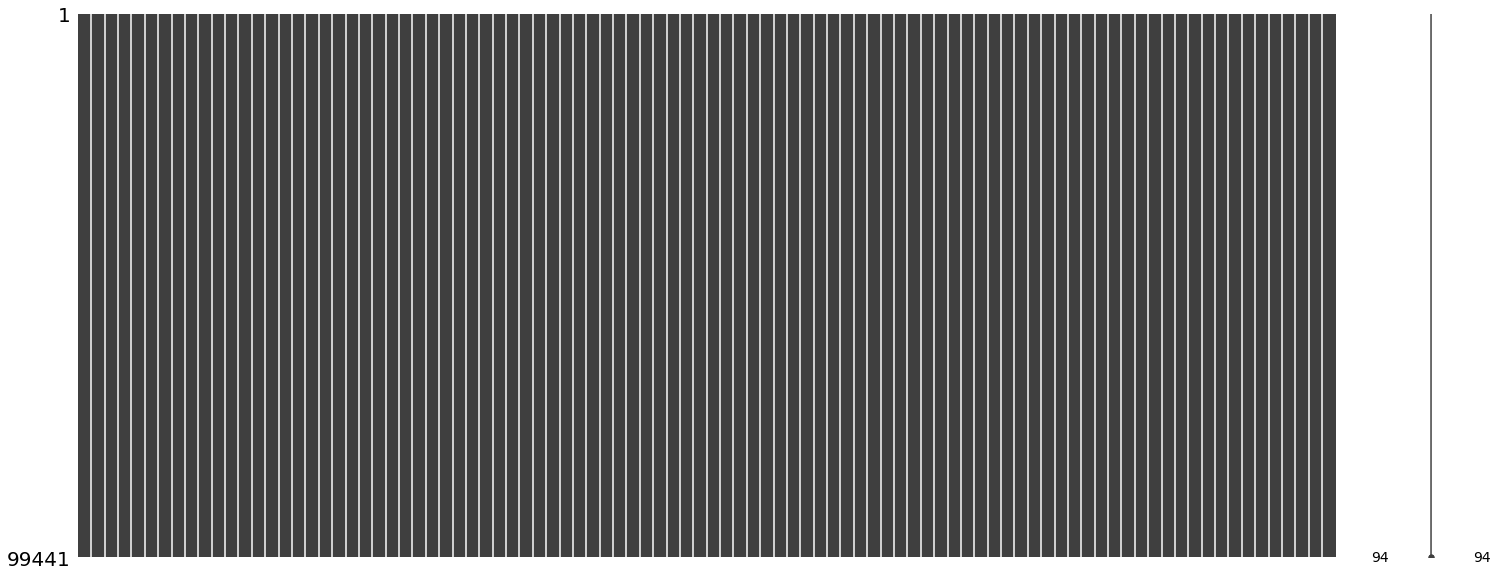

In [170]:
msno.matrix(opr_ips)

In [171]:
opr_ips.head()

,customer_id,order_purchase_timestamp,purchase_recence,delivery_delay,installments,payment_value,review_score,seller_lat,seller_lng,order_item_id,cat_agro_industria_e_comercio,cat_alimentos,cat_alimentos_bebidas,cat_artes,cat_artes_e_artesanato,cat_artigos_de_festas,cat_artigos_de_natal,cat_audio,cat_automotivo,cat_bebes,cat_bebidas,cat_beleza_saude,cat_brinquedos,cat_cama_mesa_banho,cat_casa_conforto,cat_casa_conforto_2,cat_casa_construcao,cat_cds_dvds_musicais,cat_cine_foto,cat_climatizacao,cat_consoles_games,cat_construcao_ferramentas_construcao,cat_construcao_ferramentas_ferramentas,cat_construcao_ferramentas_iluminacao,cat_construcao_ferramentas_jardim,cat_construcao_ferramentas_seguranca,cat_cool_stuff,cat_dvds_blu_ray,cat_eletrodomesticos,cat_eletrodomesticos_2,cat_eletronicos,cat_eletroportateis,cat_esporte_lazer,cat_fashion_bolsas_e_acessorios,cat_fashion_calcados,cat_fashion_esporte,cat_fashion_roupa_feminina,cat_fashion_roupa_infanto_juvenil,cat_fashion_roupa_masculina,cat_fashion_underwear_e_moda_praia,cat_ferramentas_jardim,cat_flores,cat_fraldas_higiene,cat_industria_comercio_e_negocios,cat_informatica_acessorios,cat_instrumentos_musicais,cat_la_cuisine,cat_livros_importados,cat_livros_interesse_geral,cat_livros_tecnicos,cat_malas_acessorios,cat_market_place,cat_moveis_colchao_e_estofado,cat_moveis_cozinha_area_de_servico_jantar_e_jardim,cat_moveis_decoracao,cat_moveis_escritorio,cat_moveis_quarto,cat_moveis_sala,cat_musica,cat_papelaria,cat_pc_gamer,cat_pcs,cat_perfumaria,cat_pet_shop,cat_portateis_casa_forno_e_cafe,cat_portateis_cozinha_e_preparadores_de_alimentos,cat_relogios_presentes,cat_seguros_e_servicos,cat_sinalizacao_e_seguranca,cat_tablets_impressao_imagem,cat_telefonia,cat_telefonia_fixa,cat_unknown,cat_utilidades_domesticas,cat_nan,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,order_status_nan
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,-381,-8.0,3.0,38.71,4.0,-23.669994,-46.448909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0,0,0,0,0
1,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,-85,-6.0,1.0,141.46,4.0,-19.908772,-43.957549,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
2,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,-71,-18.0,1.0,179.12,5.0,-21.363502,-48.229601,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
3,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,-333,-13.0,1.0,72.20,5.0,-19.908772,-43.957549,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
4,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,-246,-10.0,1.0,28.62,5.0,-23.530402,-46.193888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### `Customers`, `Geolocation`, et aggrégation finale

In [172]:
cus_light = cus.drop('customer_zip_code_prefix', axis=1)
cus_final = pd.merge(cus_light, opr_ips, how='left', on='customer_id')

In [173]:
cus_final = pd.merge(cus_final, cts, how='left', left_on='customer_city', right_on='city_name')
cus_final.rename(columns={'city_lat': 'customer_city_lat', 'city_lng': 'customer_city_lng'}, inplace=True)

In [174]:
for idx, row in cus_final[cus_final['city_name'].isna()].iterrows():
    cus_final.loc[cus_final['customer_id'] == row['customer_id'], 'customer_city_lat'] = float(
        sts.loc[sts['state_name'] == row['customer_state'], 'state_lat'])
    cus_final.loc[cus_final['customer_id'] == row['customer_id'], 'customer_city_lng'] = float(
        sts.loc[sts['state_name'] == row['customer_state'], 'state_lng'])

In [175]:
cus_final['distance_km'] = cus_final.apply(lambda x: calc_distance_coord(
    x['customer_city_lat'], x['customer_city_lng'], x['seller_lat'], x['seller_lng']), axis=1)

In [176]:
cus_final['purchase_month'] = cus_final['order_purchase_timestamp'].dt.month
cus_final['purchase_year'] = cus_final['order_purchase_timestamp'].dt.year

In [177]:
cus_final = cus_final.drop(['customer_id', 'customer_city', 'customer_state', 'seller_lat', 'seller_lng',
                            'city_name', 'customer_city_lat', 'customer_city_lng', 'order_purchase_timestamp'],
                           axis=1)

In [178]:
to_sum = ['customer_unique_id', 'payment_value', 'delivery_delay', 'order_item_id', 'distance_km', 'installments']
for c in cus_final.columns:
    if re.match('cat_', c) or re.match('order_status_', c):
        to_sum.append(c)
cus_final_sum = cus_final.groupby('customer_unique_id').sum().reset_index().loc[:, to_sum]
cus_final_sum = cus_final_sum.rename(columns={
    'payment_value': 'total_payment_value', 'order_item_id': 'total_nb_products', 
    'distance_km': 'total_distance_km', 'delivery_delay': 'total_delivery_delay',
    'installments': 'total_installments'})
to_mean = ['customer_unique_id', 'delivery_delay', 'installments', 'payment_value', 'review_score',
             'order_item_id', 'distance_km']
cus_final_mean = cus_final.groupby('customer_unique_id').mean().reset_index().loc[:, to_mean]
cus_final_mean = cus_final_mean.rename(columns={
    'delivery_delay': 'mean_delivery_delay', 'installments': 'mean_installments',
    'payment_value': 'mean_payment_value', 'review_score': 'mean_review_score', 
    'order_item_id': 'mean_nb_products', 'distance_km': 'mean_distance_km'})
to_recent = ['customer_unique_id', 'nb_orders', 'purchase_frequency', 'purchase_recence', 'delivery_delay', 
             'installments', 'payment_value', 'review_score', 'order_item_id', 'distance_km', 'purchase_month', 
             'purchase_year']
cus_final_latest = cus_final.sort_values(by='purchase_recence', ascending=False).drop_duplicates(
    subset='customer_unique_id', keep='first').loc[:, to_recent]
cus_final_latest = cus_final_latest.rename(columns={
    'delivery_delay': 'last_order_delivery_delay', 'installments': 'last_order_installments', 
    'payment_value': 'last_order_payment_value', 'review_score': 'last_order_review_score', 
    'order_item_id': 'last_order_nb_products', 'distance_km': 'last_order_distance_km', 
    'purchase_month': 'last_order_purchase_month', 'purchase_year': 'last_order_purchase_year'})

In [179]:
cus_final = pd.merge(cus_final_mean, cus_final_latest, how='left', on='customer_unique_id')
cus_final = pd.merge(cus_final, cus_final_sum, how='left', on='customer_unique_id')

In [180]:
cus_final.to_csv('data/featured.csv', index=False)

In [181]:
cus_final.shape

(96096, 107)

In [182]:
cus_final.head()

,customer_unique_id,mean_delivery_delay,mean_installments,mean_payment_value,mean_review_score,mean_nb_products,mean_distance_km,nb_orders,purchase_frequency,purchase_recence,last_order_delivery_delay,last_order_installments,last_order_payment_value,last_order_review_score,last_order_nb_products,last_order_distance_km,last_order_purchase_month,last_order_purchase_year,total_payment_value,total_delivery_delay,total_nb_products,total_distance_km,total_installments,cat_agro_industria_e_comercio,cat_alimentos,cat_alimentos_bebidas,cat_artes,cat_artes_e_artesanato,cat_artigos_de_festas,cat_artigos_de_natal,cat_audio,cat_automotivo,cat_bebes,cat_bebidas,cat_beleza_saude,cat_brinquedos,cat_cama_mesa_banho,cat_casa_conforto,cat_casa_conforto_2,cat_casa_construcao,cat_cds_dvds_musicais,cat_cine_foto,cat_climatizacao,cat_consoles_games,cat_construcao_ferramentas_construcao,cat_construcao_ferramentas_ferramentas,cat_construcao_ferramentas_iluminacao,cat_construcao_ferramentas_jardim,cat_construcao_ferramentas_seguranca,cat_cool_stuff,cat_dvds_blu_ray,cat_eletrodomesticos,cat_eletrodomesticos_2,cat_eletronicos,cat_eletroportateis,cat_esporte_lazer,cat_fashion_bolsas_e_acessorios,cat_fashion_calcados,cat_fashion_esporte,cat_fashion_roupa_feminina,cat_fashion_roupa_infanto_juvenil,cat_fashion_roupa_masculina,cat_fashion_underwear_e_moda_praia,cat_ferramentas_jardim,cat_flores,cat_fraldas_higiene,cat_industria_comercio_e_negocios,cat_informatica_acessorios,cat_instrumentos_musicais,cat_la_cuisine,cat_livros_importados,cat_livros_interesse_geral,cat_livros_tecnicos,cat_malas_acessorios,cat_market_place,cat_moveis_colchao_e_estofado,cat_moveis_cozinha_area_de_servico_jantar_e_jardim,cat_moveis_decoracao,cat_moveis_escritorio,cat_moveis_quarto,cat_moveis_sala,cat_musica,cat_papelaria,cat_pc_gamer,cat_pcs,cat_perfumaria,cat_pet_shop,cat_portateis_casa_forno_e_cafe,cat_portateis_cozinha_e_preparadores_de_alimentos,cat_relogios_presentes,cat_seguros_e_servicos,cat_sinalizacao_e_seguranca,cat_tablets_impressao_imagem,cat_telefonia,cat_telefonia_fixa,cat_unknown,cat_utilidades_domesticas,cat_nan,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,order_status_nan
0,0000366f3b9a7992bf8c76cfdf3221e2,-5.0,1.0,141.90,5.0,1.0,108.981774,1,0.038462,-161,-5.0,1.0,141.90,5.0,1.0,108.981774,5,2018,141.90,-5.0,1.0,108.981774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-5.0,1.0,27.19,4.0,1.0,16.279123,1,0.038462,-164,-5.0,1.0,27.19,4.0,1.0,16.279123,5,2018,27.19,-5.0,1.0,16.279123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,-2.0,1.0,86.22,3.0,1.0,518.656568,1,0.038462,-586,-2.0,1.0,86.22,3.0,1.0,518.656568,3,2017,86.22,-2.0,1.0,518.656568,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,-12.0,1.0,43.62,4.0,1.0,2454.492880,1,0.038462,-370,-12.0,1.0,43.62,4.0,1.0,2454.492880,10,2017,43.62,-12.0,1.0,2454.492880,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [183]:
cus_final.describe(include='all')

,customer_unique_id,mean_delivery_delay,mean_installments,mean_payment_value,mean_review_score,mean_nb_products,mean_distance_km,nb_orders,purchase_frequency,purchase_recence,last_order_delivery_delay,last_order_installments,last_order_payment_value,last_order_review_score,last_order_nb_products,last_order_distance_km,last_order_purchase_month,last_order_purchase_year,total_payment_value,total_delivery_delay,total_nb_products,total_distance_km,total_installments,cat_agro_industria_e_comercio,cat_alimentos,cat_alimentos_bebidas,cat_artes,cat_artes_e_artesanato,cat_artigos_de_festas,cat_artigos_de_natal,cat_audio,cat_automotivo,cat_bebes,cat_bebidas,cat_beleza_saude,cat_brinquedos,cat_cama_mesa_banho,cat_casa_conforto,cat_casa_conforto_2,cat_casa_construcao,cat_cds_dvds_musicais,cat_cine_foto,cat_climatizacao,cat_consoles_games,cat_construcao_ferramentas_construcao,cat_construcao_ferramentas_ferramentas,cat_construcao_ferramentas_iluminacao,cat_construcao_ferramentas_jardim,cat_construcao_ferramentas_seguranca,cat_cool_stuff,cat_dvds_blu_ray,cat_eletrodomesticos,cat_eletrodomesticos_2,cat_eletronicos,cat_eletroportateis,cat_esporte_lazer,cat_fashion_bolsas_e_acessorios,cat_fashion_calcados,cat_fashion_esporte,cat_fashion_roupa_feminina,cat_fashion_roupa_infanto_juvenil,cat_fashion_roupa_masculina,cat_fashion_underwear_e_moda_praia,cat_ferramentas_jardim,cat_flores,cat_fraldas_higiene,cat_industria_comercio_e_negocios,cat_informatica_acessorios,cat_instrumentos_musicais,cat_la_cuisine,cat_livros_importados,cat_livros_interesse_geral,cat_livros_tecnicos,cat_malas_acessorios,cat_market_place,cat_moveis_colchao_e_estofado,cat_moveis_cozinha_area_de_servico_jantar_e_jardim,cat_moveis_decoracao,cat_moveis_escritorio,cat_moveis_quarto,cat_moveis_sala,cat_musica,cat_papelaria,cat_pc_gamer,cat_pcs,cat_perfumaria,cat_pet_shop,cat_portateis_casa_forno_e_cafe,cat_portateis_cozinha_e_preparadores_de_alimentos,cat_relogios_presentes,cat_seguros_e_servicos,cat_sinalizacao_e_seguranca,cat_tablets_impressao_imagem,cat_telefonia,cat_telefonia_fixa,cat_unknown,cat_utilidades_domesticas,cat_nan,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,order_status_nan
count,96096,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.00000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.0
unique,96096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

[*(Retour sommaire)*](#ch0)

# <div id="ch5" style="color: blue">5. Conclusion</div>

Nous venons de conclure l'analyse du jeu de donnée Olist par deux feature engineering très différents :

1. Le premier, basé sur des métriques marketing bien connues, comprend peu de détail mais sera digeste pour un K-means (6 variables)
2. Le second, englobant la plupart des variables d'intérêt que nous avons souligné durant la phase d'analyse, offre plus de possibilités du haut de ses 106 variables et s'intéresse aux clients sous des angles plus originaux (distance par rapport aux fournisseurs, notes de satisfaction, etc.), mais devra faire l'objet d'une sélection lors de la phase de segmentation

Au cours du notebook suivant, nous allons passer nos deux datasets à plusieurs algorithmes de segmentation non supervisés (K-mean, DB-Scan, AgglomerativeClustering) en tentant de tirer le meilleur parti des variables que nous avons calculées.

[*(Retour sommaire)*](#ch0)